## Winton stock market prediction

### Business/Real-world problem

Stock market data given for few companies for 2 hours and next 1 hour of data to be predicted along with next 2 days.
Returns - Percentage of amount we get if we buy at that time

### ML Formulation of business problem

#### Data Overview

Input contains the below values
- ID Column
- Feature_1 to Feature_25 - Anonymous features
- Ret_MinusTwo and Ret_MinusOne - Last 2 days of return in train and test data set
- Ret_2 to Ret_120 - 2 Hours of stock returns present both in train and test data set
- Ret_121 to Ret_180 - Next 1 hour of return in only train dataset and need to predict it
- Ret_PlusOne and Ret_PlusTwo - Next 2 days of return in train data set and need to predict it
- Weight_Intraday and Weight_Daily weights corresponding to hourly and daily returns


Predict each minute of data from Ret_121 to Ret_180 along with Ret_PlusOne and Ret_PlusTwo by using all the previous return data and the anonumous features.

### Need for ML Formualtion

- Based on the historical data (last 2 days and last 2 hours) predict next 1 hour and 2 days of stock return values
- With around 120K data points and 62 target variables need to be predicted with accuracy we need ML models to predict them rather than statistical tests

### Business constraints

- No Low latency requirements
- Interpretability is not so important

### Performance Metrics

- MAE - Mean Absolute Error (We do not need to penalize large errors and is the evalution metric which needs to be optimized and is suitable for financial data)

#### EDA

In [10]:
!pip install h5py==2.8.0

  Using cached https://files.pythonhosted.org/packages/12/6c/00c38c5ce9322f1cc421d93217c44739646a106c61859622eccc297a5c05/h5py-2.8.0-cp36-cp36m-win_amd64.whl
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


tensorflow 2.2.0 has requirement h5py<2.11.0,>=2.10.0, but you'll have h5py 2.8.0 which is incompatible.
tensorflow-gpu 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
tensorflow-gpu 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 2.2.2 which is incompatible.
requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
botocore 1.14.9 has requirement urllib3<1.26,>=1.20, but you'll have urllib3 1.26.4 which is incompatible.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\THIYAG~1\\AppData\\Local\\Temp\\pip-uninstall-ixmwmoak\\users\\thiyagarajan\\appdata\\roaming\\python\\python36\\site-packages\\h5py\\defs.cp36-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'python -m p

In [285]:
''' Importing the packages'''
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import keras
from keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [286]:
''' Setting column display limit and reading the train file '''
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 30)
pd.set_option('mode.chained_assignment',None)
df = pd.read_csv(r'C:\Users\thiyagarajan\Downloads\aaic\case_study1\data\winton_stock\train\train.csv')


In [287]:
''' Basic information of dataset'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 211 entries, Id to Weight_Daily
dtypes: float64(209), int64(2)
memory usage: 64.4 MB


In [288]:
''' Checking the percentiles minimum maximum value for understanding the data '''
desc = df.describe(percentiles=[.1,.3,.5,.7,.9])
desc

Id    Feature_1     Feature_2     Feature_3     Feature_4  \
count  40000.00000  6687.000000  30854.000000  38763.000000  32279.000000   
mean   20000.50000     3.590250     -0.117558      0.558392      0.405572   
std    11547.14972     2.798532      1.236250      0.902233      0.799082   
min        1.00000     1.000000     -3.440521     -4.643526     -5.440596   
10%     4000.90000     1.000000     -1.446893     -0.484413     -0.610787   
30%    12000.70000     1.000000     -0.847088      0.001605     -0.004713   
50%    20000.50000     3.000000     -0.389162      0.437228      0.403516   
70%    28000.30000     5.000000      0.179738      0.912392      0.825183   
90%    36000.10000     8.000000      1.850024      1.796770      1.442370   
max    40000.00000    10.000000      4.175150      4.530405      2.953163   

          Feature_5     Feature_6     Feature_7     Feature_8     Feature_9  \
count  40000.000000  38067.000000  40000.000000  39531.000000  38125.000000   
mean       5.482775      0.430972  49244.971525      0.196958     10.680289   
std        2.942324      1.498274  28242.409717      0.138485      2.850634   
min        1.000000     -0.936644    338.000000      0.009800      0.000000   
10%        1.000000     -0.466585   9545.000000      0.010500      7.000000   
30%        3.000000     -0.206531  30848.000000      0.017400      9.000000   
50%        6.000000      0.055564  48457.000000      0.213800     11.000000   
70%        8.000000      0.425265  67409.000000      0.331800     12.000000   
90%        9.000000      1.289952  88794.000000      0.365000     14.000000   
max       10.000000     12.609885  99861.000000      0.365000     36.000000   

         Feature_10    Feature_11  ...       Ret_173       Ret_174  \
count  20529.000000  39013.000000  ...  40000.000000  4.000000e+04   
mean       4.744703     -0.572244  ...      0.000034 -1.729004e-05   
std        0.865096      1.246347  ...      0.001161  1.148816e-03   
min        1.000000     -7.359120  ...     -0.024382 -4.849509e-02   
10%        4.000000     -2.208243  ...     -0.000916 -9.781689e-04   
30%        5.000000     -0.936240  ...     -0.000253 -2.738869e-04   
50%        5.000000     -0.324923  ...      0.000002  1.489203e-07   
70%        5.000000      0.191222  ...      0.000291  2.695590e-04   
90%        5.000000      0.725634  ...      0.000987  9.424752e-04   
max        6.000000      1.786886  ...      0.074885  1.399997e-02   

            Ret_175       Ret_176       Ret_177       Ret_178       Ret_179  \
count  40000.000000  4.000000e+04  4.000000e+04  4.000000e+04  40000.000000   
mean       0.000049 -3.580980e-06 -9.675766e-06 -1.268935e-05     -0.000017   
std        0.001115  1.166019e-03  1.248956e-03  1.217967e-03      0.001208   
min       -0.018048 -1.786752e-02 -3.526027e-02 -4.864099e-02     -0.037215   
10%       -0.000855 -1.016825e-03 -1.044689e-03 -9.409432e-04     -0.000952   
30%       -0.000221 -2.852265e-04 -2.953161e-04 -2.624240e-04     -0.000258   
50%        0.000004 -4.039616e-07  4.016833e-07  6.407432e-07      0.000001   
70%        0.000304  2.773886e-04  3.066661e-04  2.740139e-04      0.000279   
90%        0.000998  9.699709e-04  1.039397e-03  9.480998e-04      0.000923   
max        0.020781  3.061460e-02  4.406460e-02  2.922928e-02      0.048221   

            Ret_180   Ret_PlusOne   Ret_PlusTwo  Weight_Intraday  Weight_Daily  
count  40000.000000  40000.000000  40000.000000     4.000000e+04  4.000000e+04  
mean      -0.000057     -0.000210      0.000012     1.504600e+06  1.880750e+06  
std        0.001270      0.025039      0.024160     2.059143e+05  2.573928e+05  
min       -0.058046     -0.627690     -0.450779     1.000035e+06  1.250044e+06  
10%       -0.001052     -0.023621     -0.022632     1.264694e+06  1.580868e+06  
30%       -0.000303     -0.008041     -0.007621     1.382962e+06  1.728702e+06  
50%       -0.000002     -0.000258     -0.000258     1.477713e+06  1.847142e+06  
70%      

In [289]:
''' Calculating missing percentage of data '''
transposed = desc.T
transposed['Missing'] = (len(df) - transposed['count']) *100/len(df)
top_30_miss=transposed['Missing'].sort_values(ascending=False).head(30)

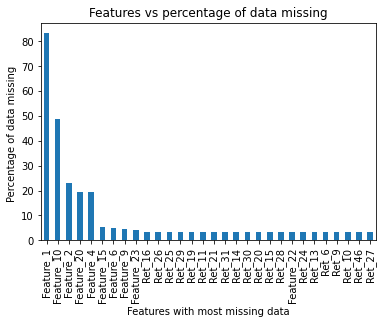

In [290]:
''' Plotting percentage of data missing'''
top_30_miss.plot.bar()
plt.xlabel('Features with most missing data')
plt.ylabel('Percentage of data missing ')
plt.title('Features vs percentage of data missing')
plt.show()

Feature_1, Feature_10, Feature_2, Feature_20, Feature_4 has greater than 20% missing data
and can be removed during feature selection

In [291]:
''' Filtering ret_2 to ret_180 '''
##daily_returns = transposed_return_filled[2:-2:]
return_df = df.filter(like='Ret_')
minute_daily_returns = return_df.T
return_df['all_ret'] = return_df.sum(axis = 1, skipna = True ) 

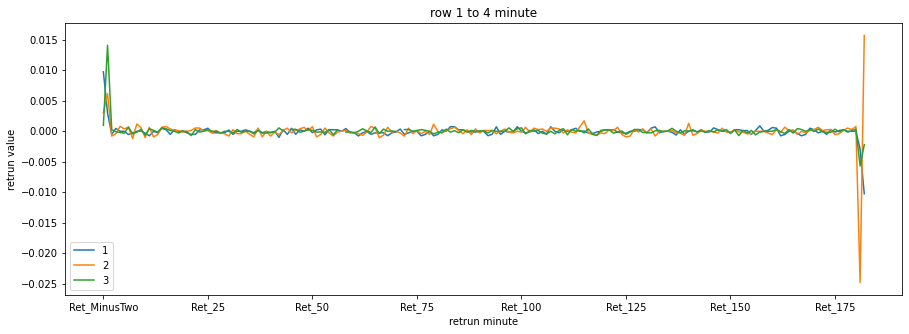

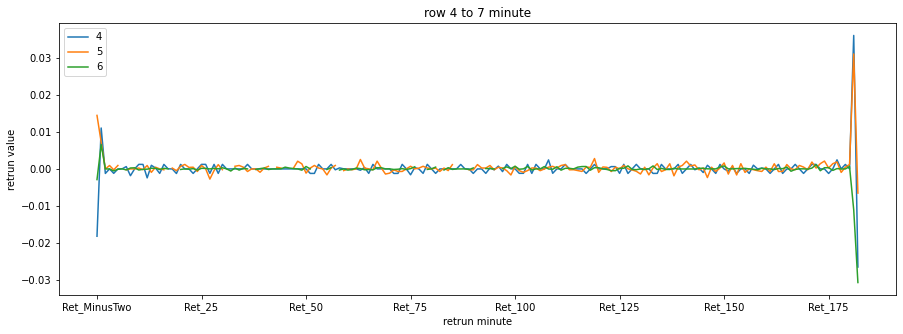

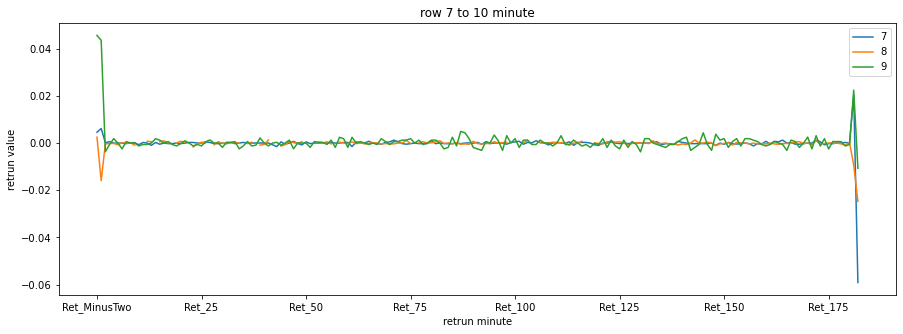

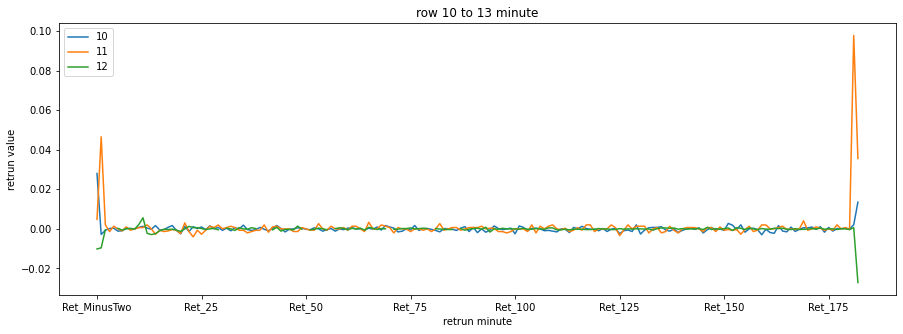

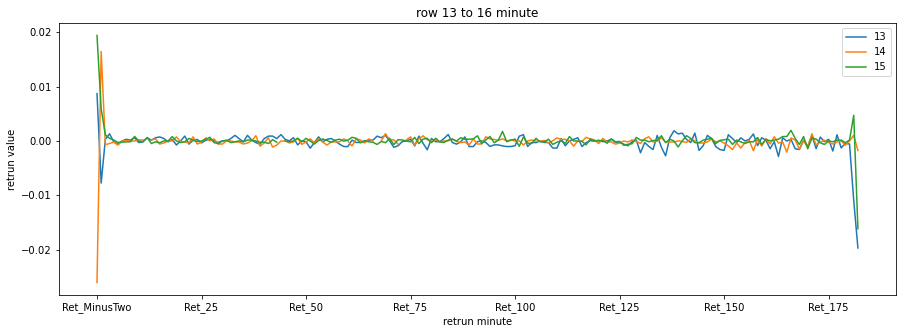

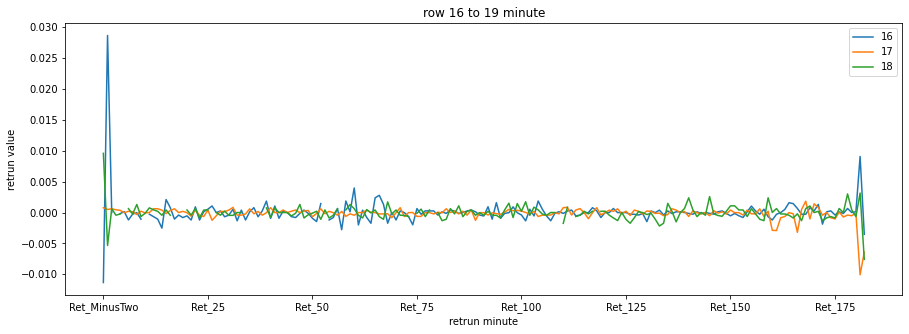

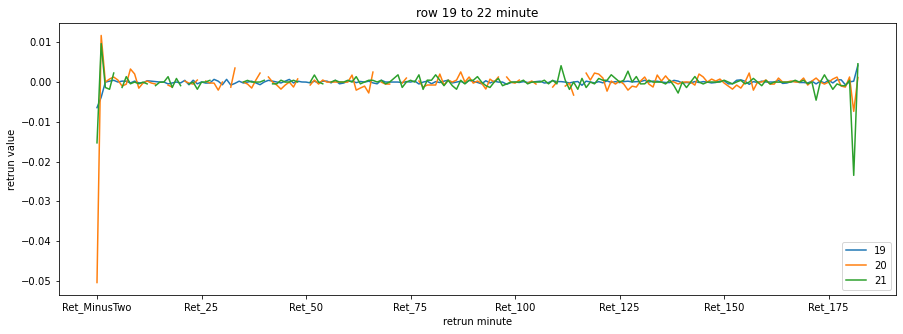

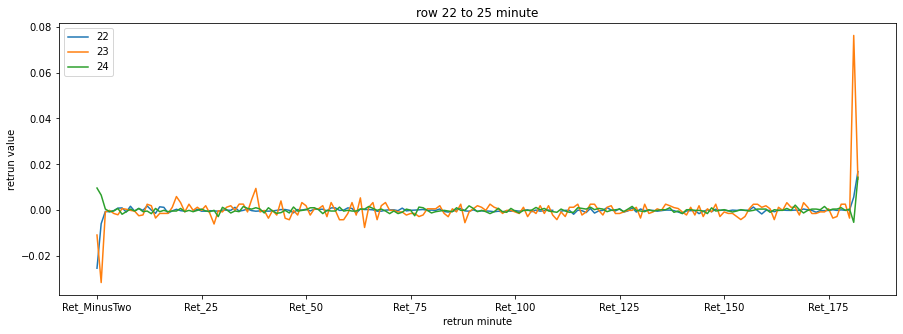

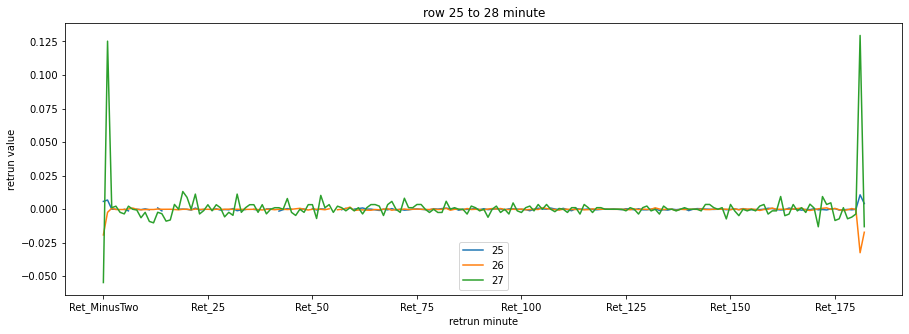

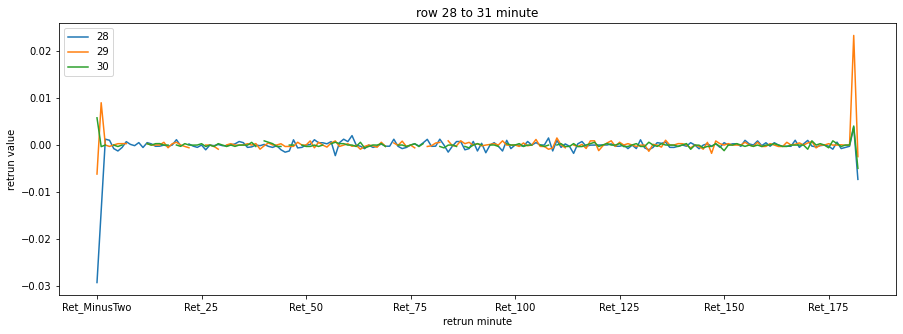

In [292]:
''' Plotting every 3 rows together to identify the correlation for both minute and daily data '''
for i in range(1,30,3):
    minute_daily_returns.iloc[:,i:i+3].plot(figsize=(15,5),title='row '+str(i)+' to ' + str(i+3)+' minute')
    plt.xlabel('retrun minute')
    plt.ylabel('retrun value')
    plt.show()

From this plot we could see there are huge variations between minute data and daily data so seperating them and plotting independantly

In [293]:
minute_returns = minute_daily_returns[2:-2:]

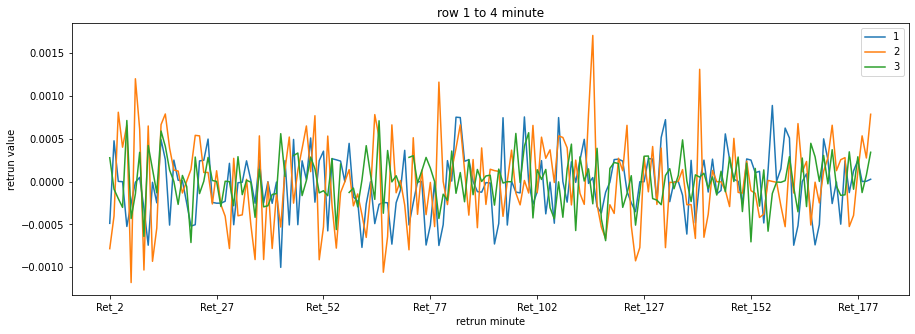

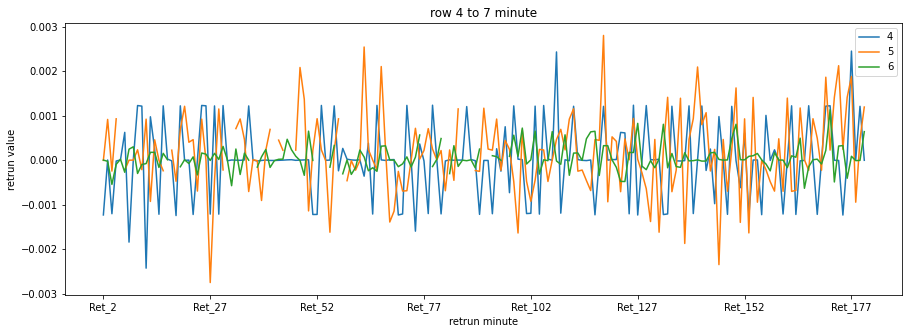

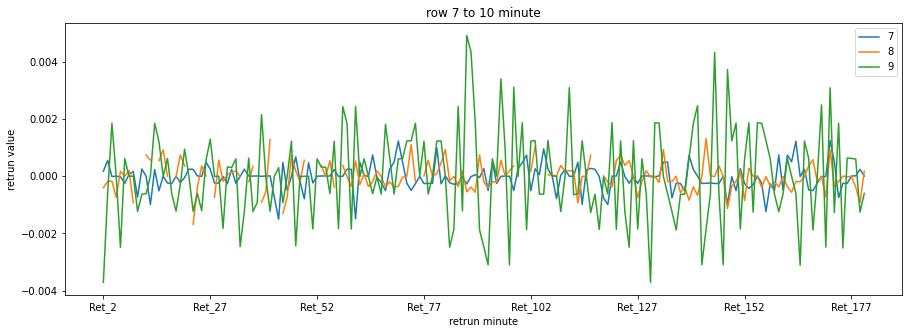

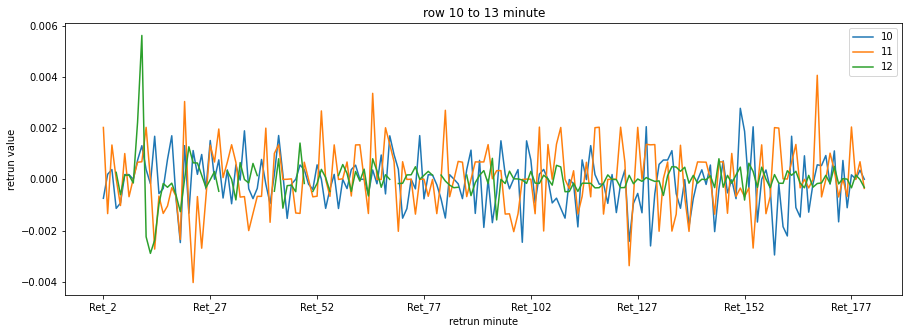

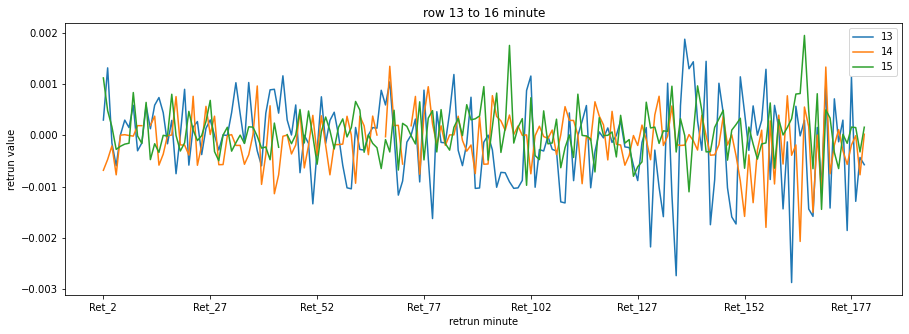

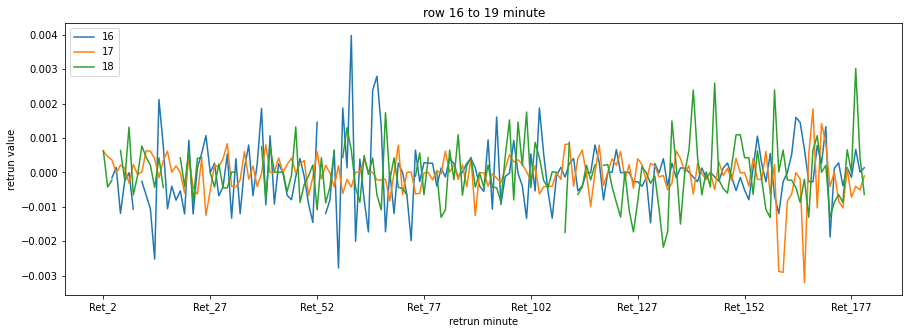

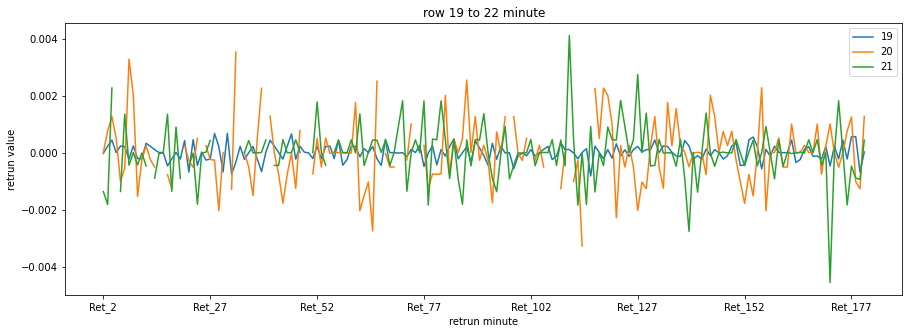

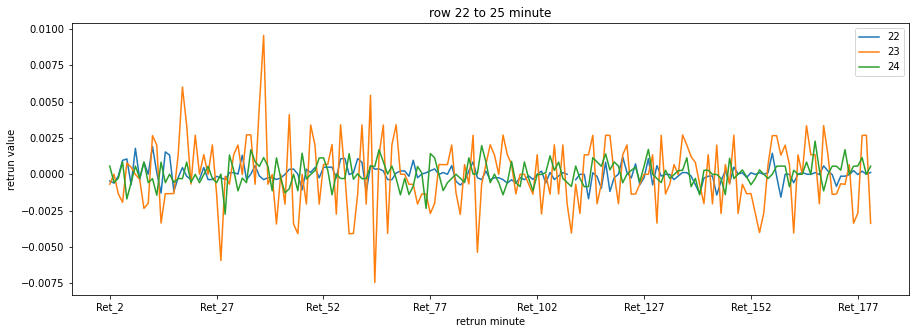

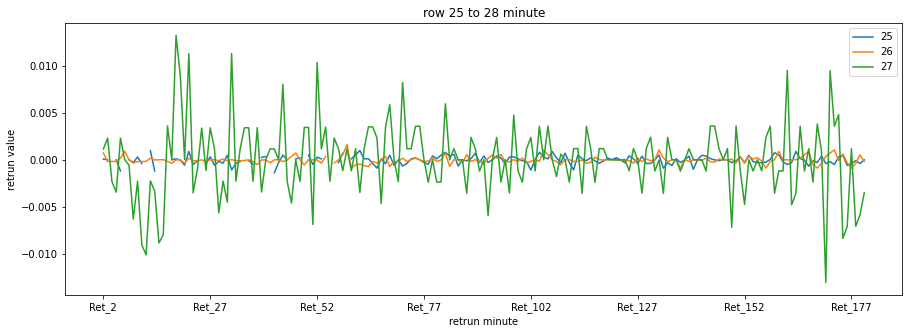

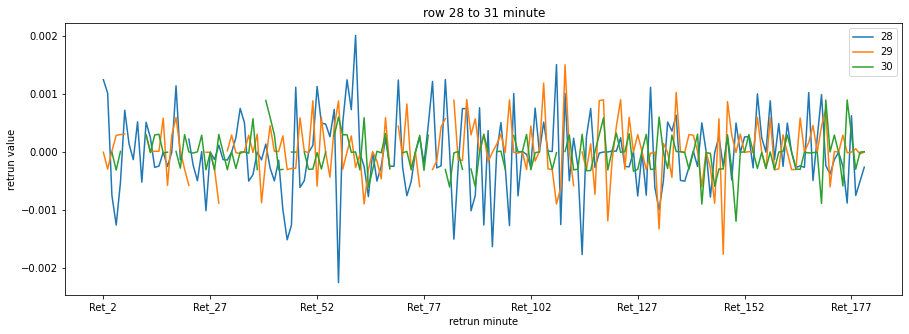

In [294]:
''' Plotting every 3 rows together to identify the correlation for both minute and daily data '''
for i in range(1,30,3):
    minute_returns.iloc[:,i:i+3].plot(figsize=(15,5),title='row '+str(i)+' to ' + str(i+3)+' minute')
    plt.xlabel('retrun minute')
    plt.ylabel('retrun value')
    plt.show()

We could not identify any trend in the minute data
Different rows given in the train dataset does not have any relation between them

In [295]:
''' Filtering Ret-1 to Ret+2'''
weekly_return = pd.concat([minute_daily_returns.head(2),minute_daily_returns.tail(2)])

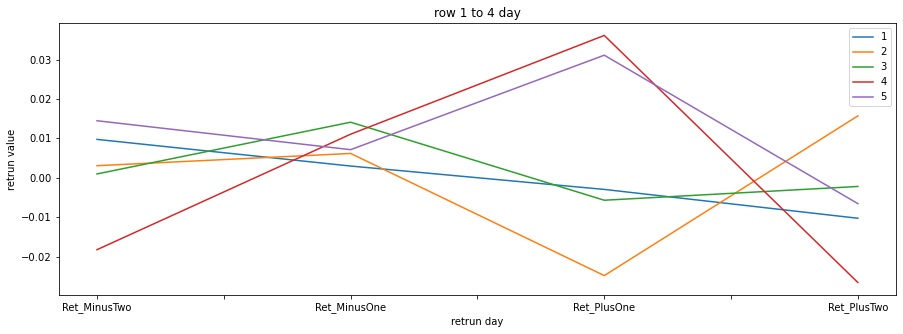

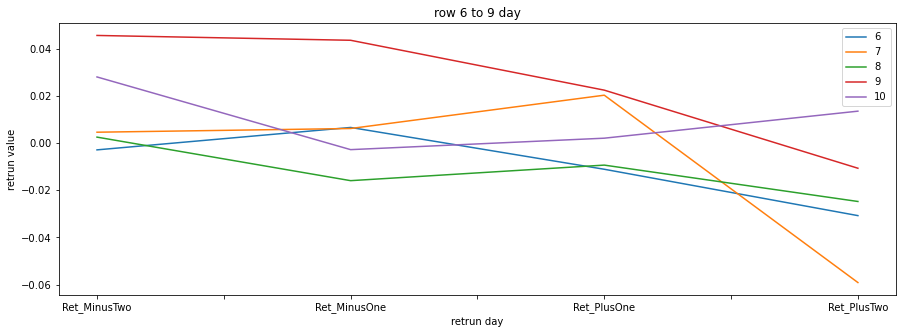

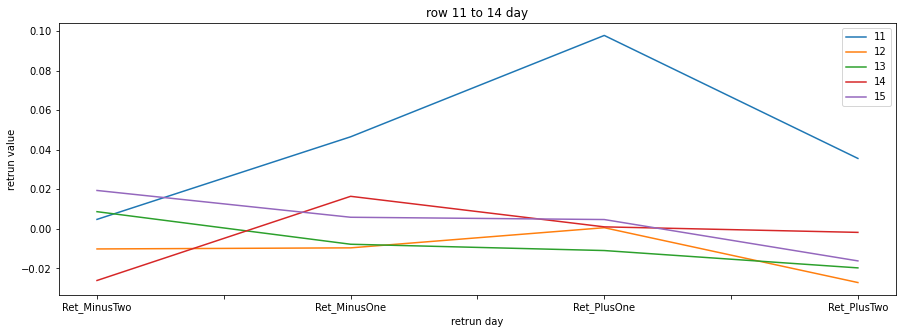

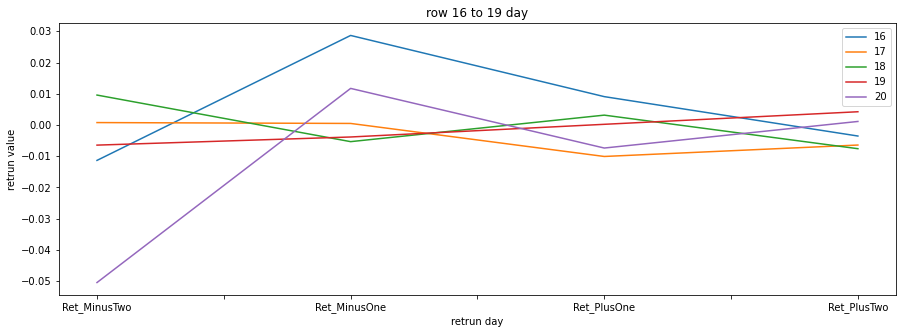

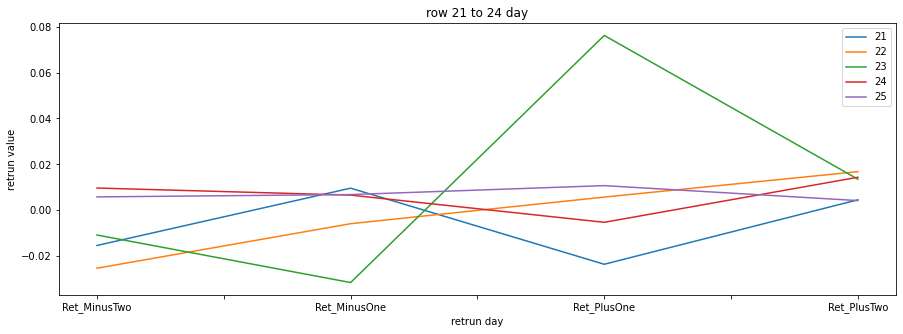

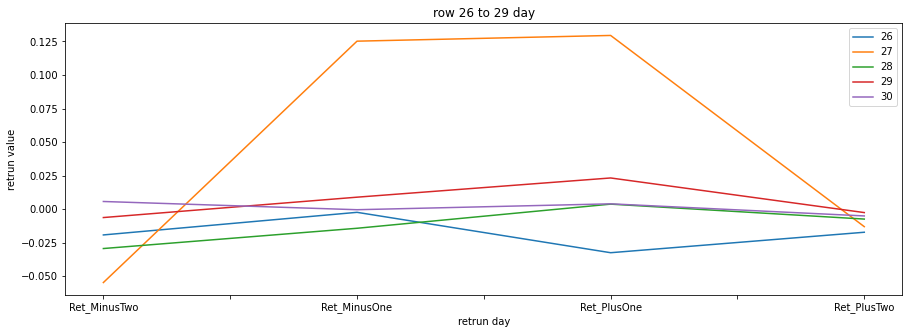

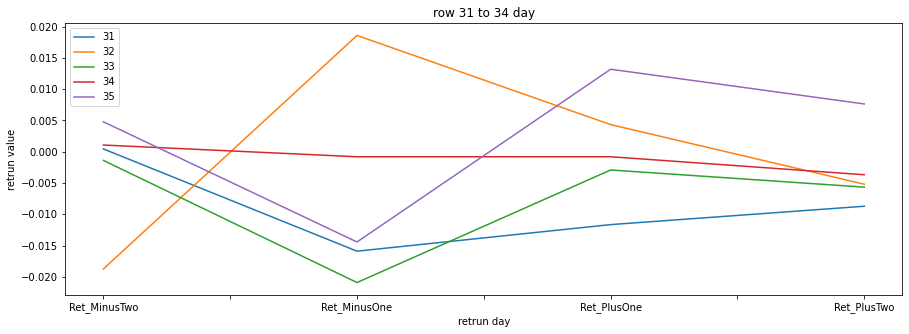

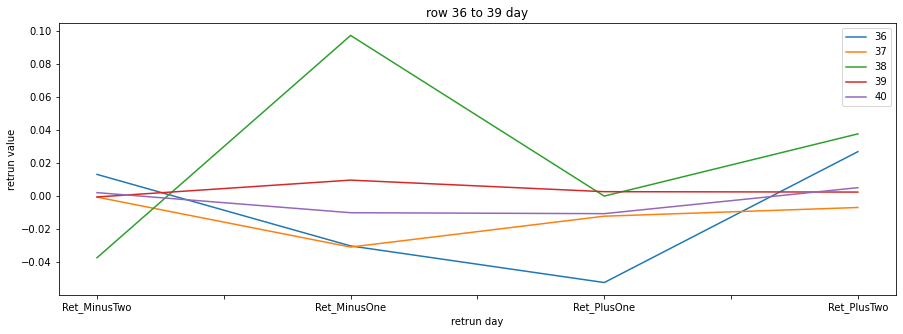

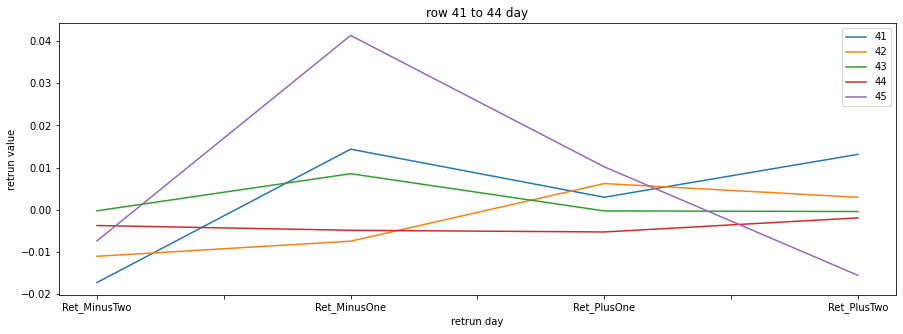

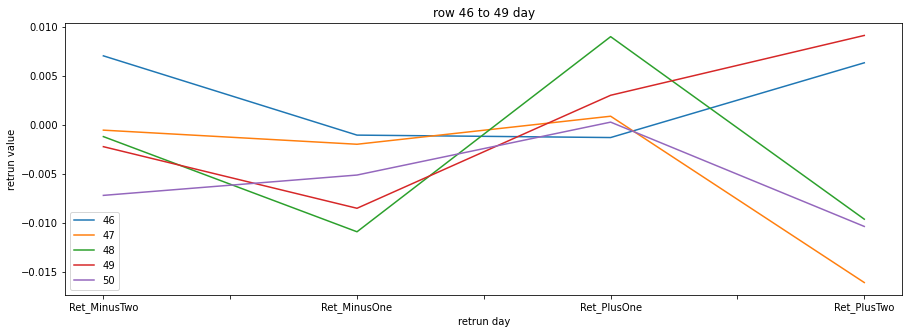

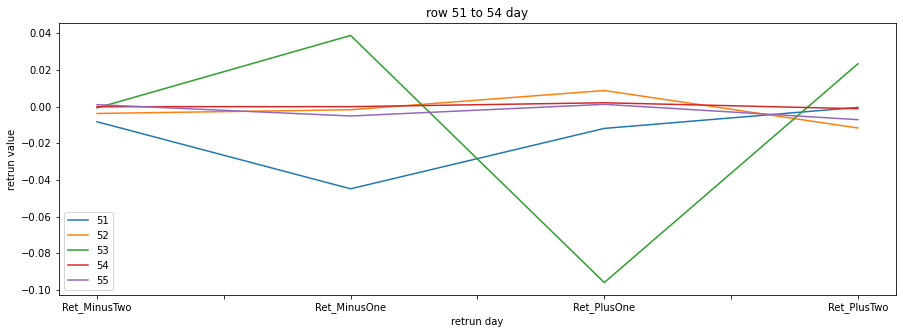

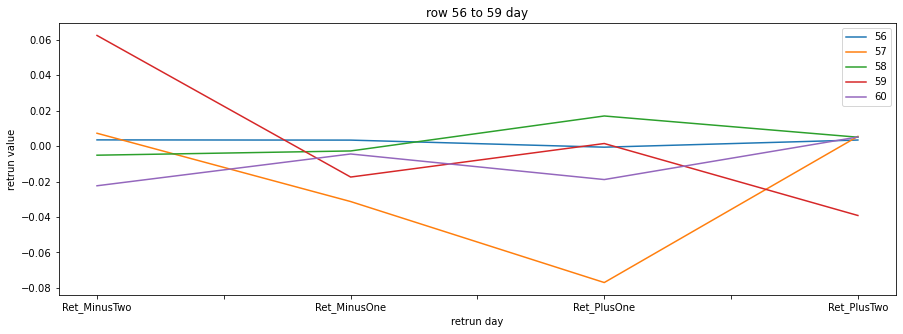

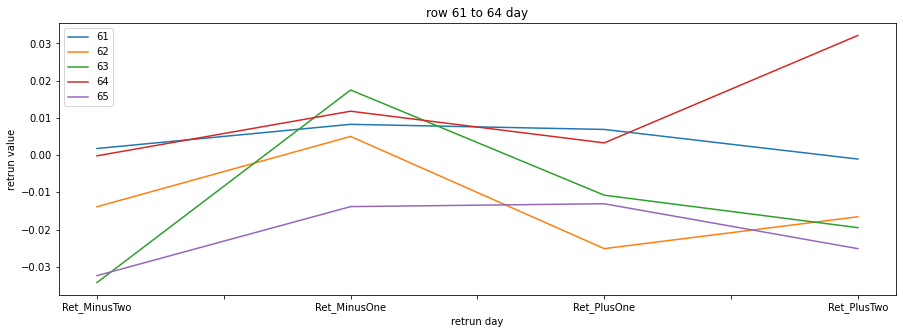

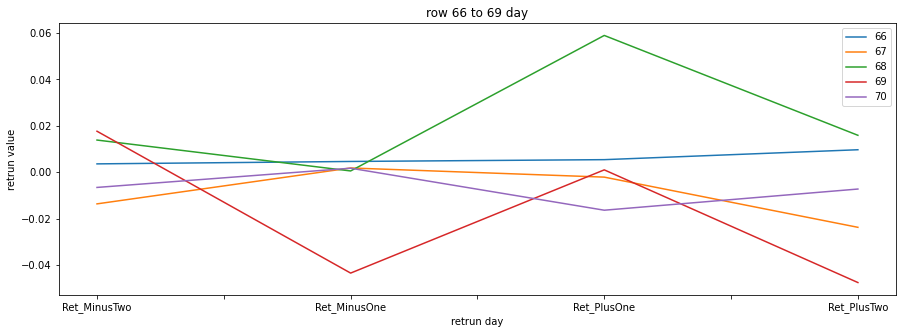

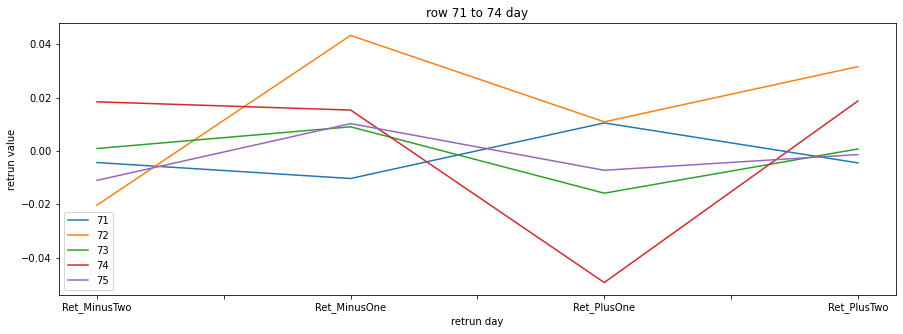

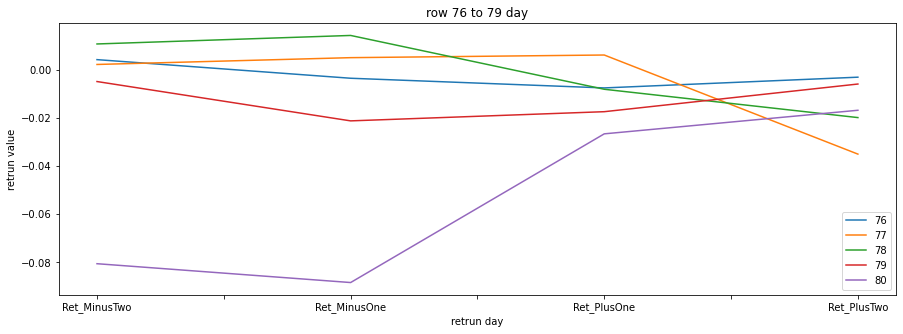

In [296]:
''' Plotting 4 days of return for every 5 rows '''
for i in range(1,80,5):
    weekly_return.iloc[:,i:i+5].plot(figsize=(15,5),title='row '+str(i)+' to ' + str(i+3)+' day')
    plt.xlabel('retrun day')
    plt.ylabel('retrun value')
    plt.show()

We could see huge variation from Ret+1 and Ret+2 mostly Ret+2 is less than Ret+1

No Relation from a random violin plot between ordinal variable and Ret_PlusOne

In [297]:
non_return_df = df.iloc[:,1:26].join( df.iloc[:,-2:])

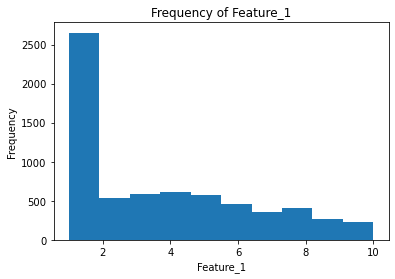

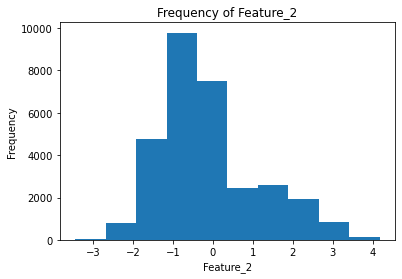

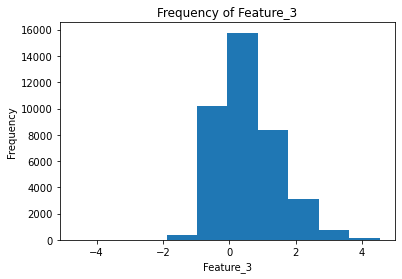

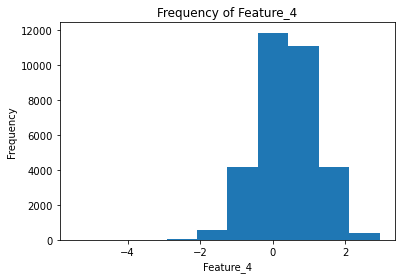

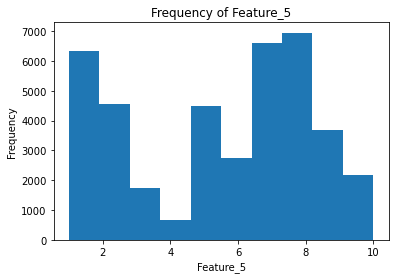

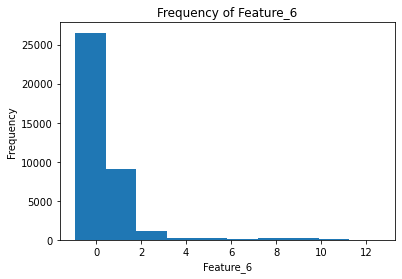

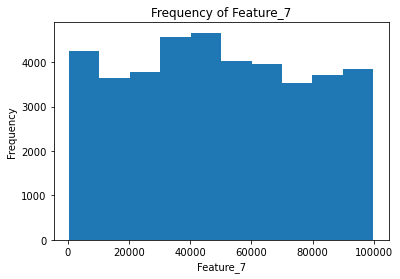

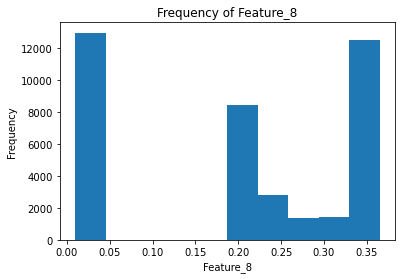

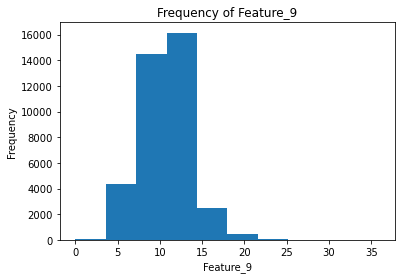

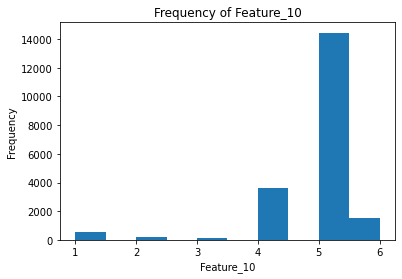

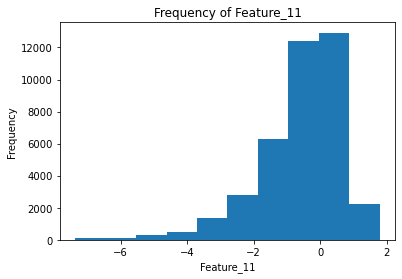

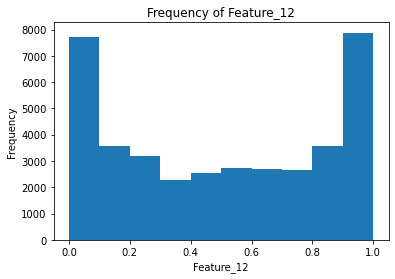

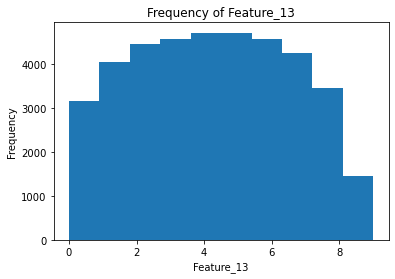

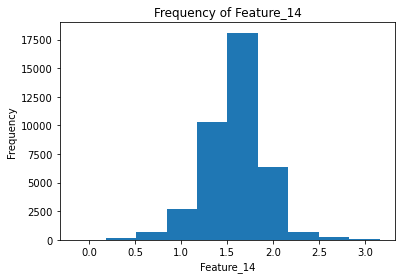

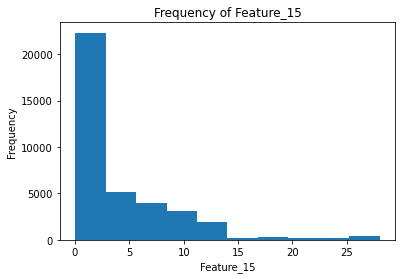

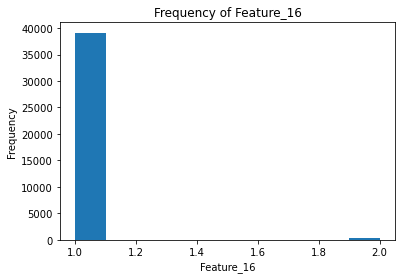

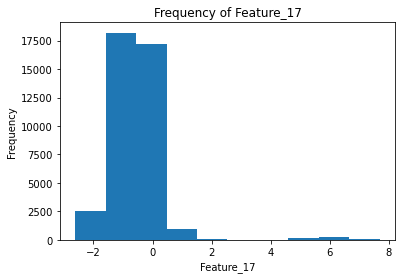

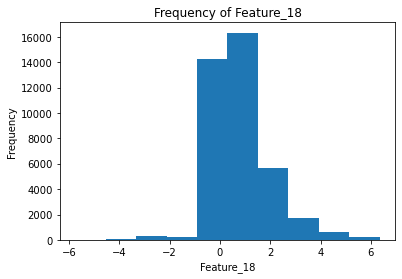

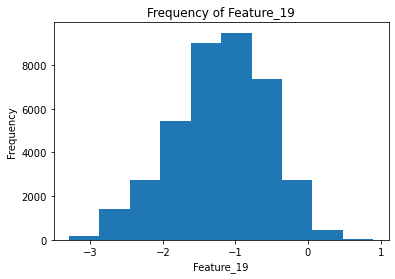

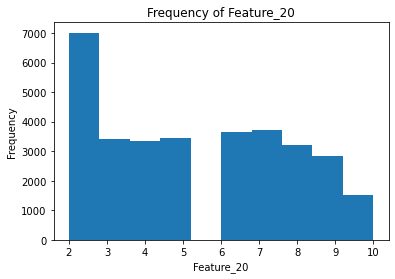

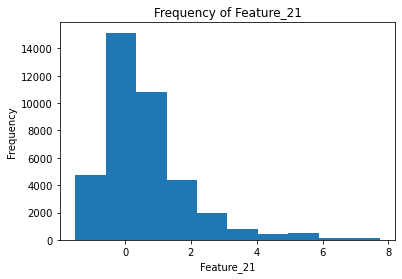

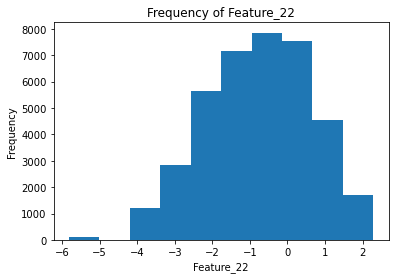

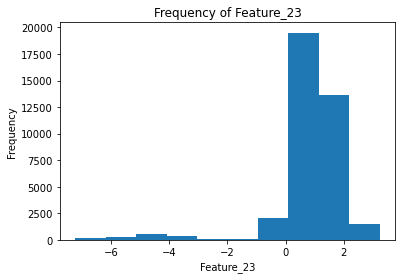

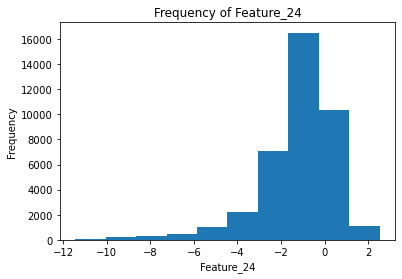

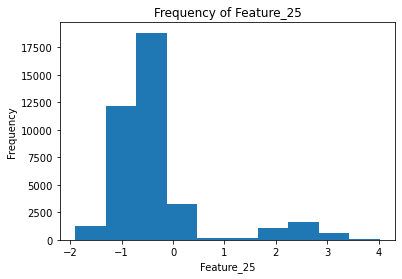

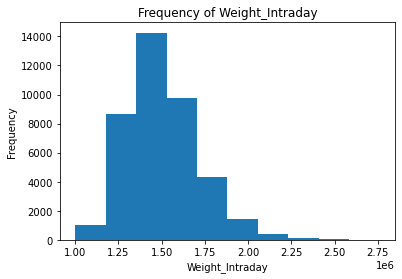

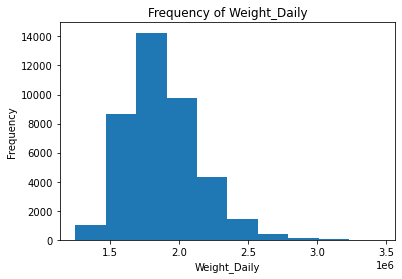

In [298]:
''' Plotting frequency of each feature after dropping na values'''
for column in list(non_return_df.columns):
    plt.hist(non_return_df[column].dropna())
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title('Frequency of ' + column)
    plt.show()

Feature_2,Feature_3,Feature_4, Weight_Intraday, Weight_Daily follow normal distribution while others do not

In [299]:
''' Feature and ret+1, ret+2 '''
feature_plus_return = non_return_df.join(weekly_return.T).join(return_df['all_ret'])

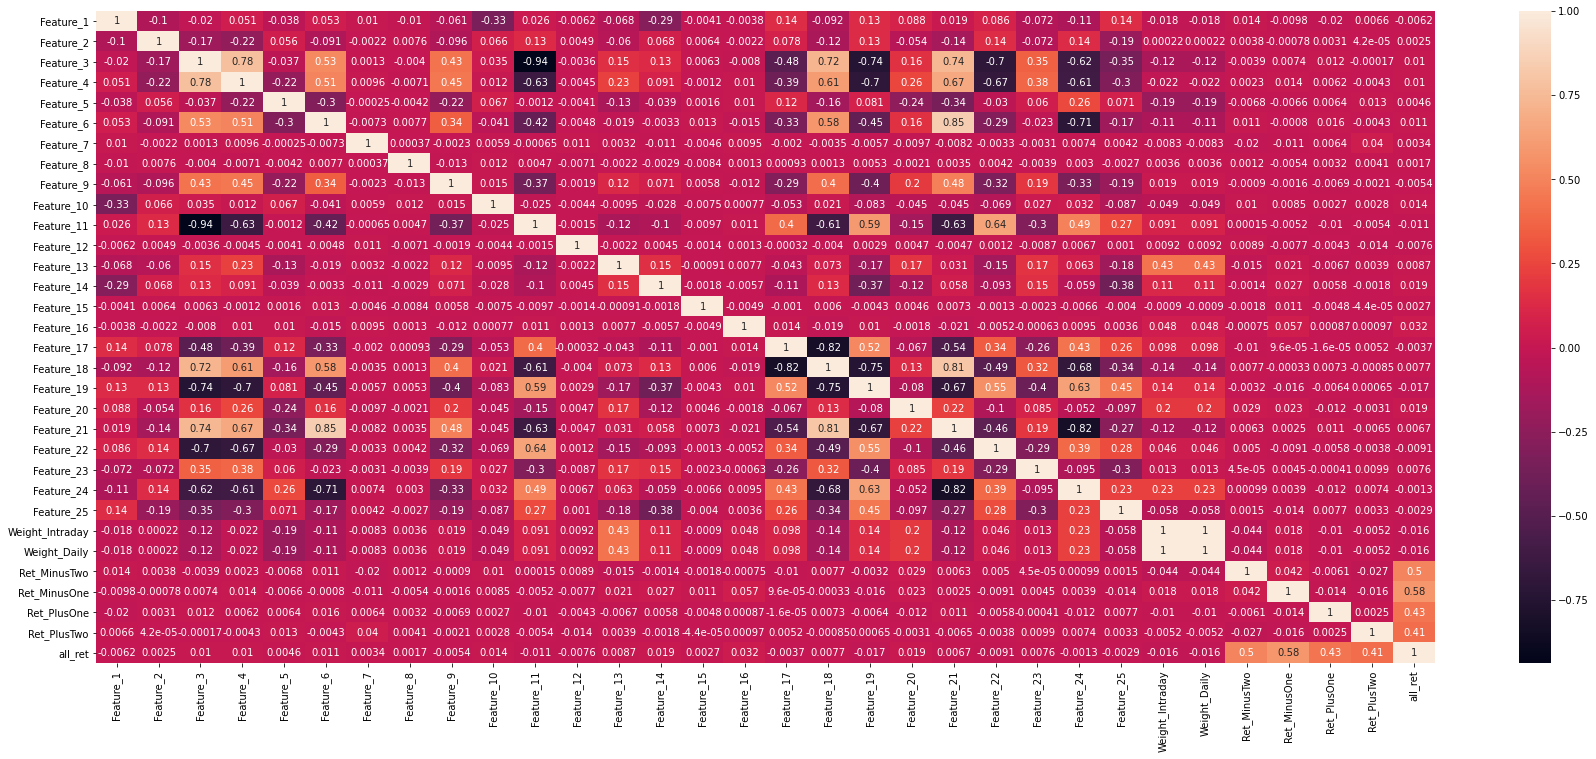

In [300]:
''' Getting correlation matrix '''
correlation = feature_plus_return.corr()

''' Plotting correlation with values '''
plt.figure(figsize = (30,12))
sns.heatmap(correlation, annot=True)
plt.show()

From the correlation plot we could see all the features contribute almost similar amount to the Ret+2 and Ret+1

Negative correlation between Feature_3 and Feature_11, Feature_6 and Feature_24
Positive Correlation between Feature_3 and Feature_4  similarly Feature_6 and Feature_21 are highly correlated.

Sum of returns is higly correlated with weekly returns (Ret_MinusTwo, Ret_MinusOne, Ret_PlusOne, Ret_PlusTwo

In [301]:
target_df = df.iloc[:,-64:].join(return_df['all_ret'])

In [302]:
''' Getting correlation matrix '''
correlation = target_df.corr()

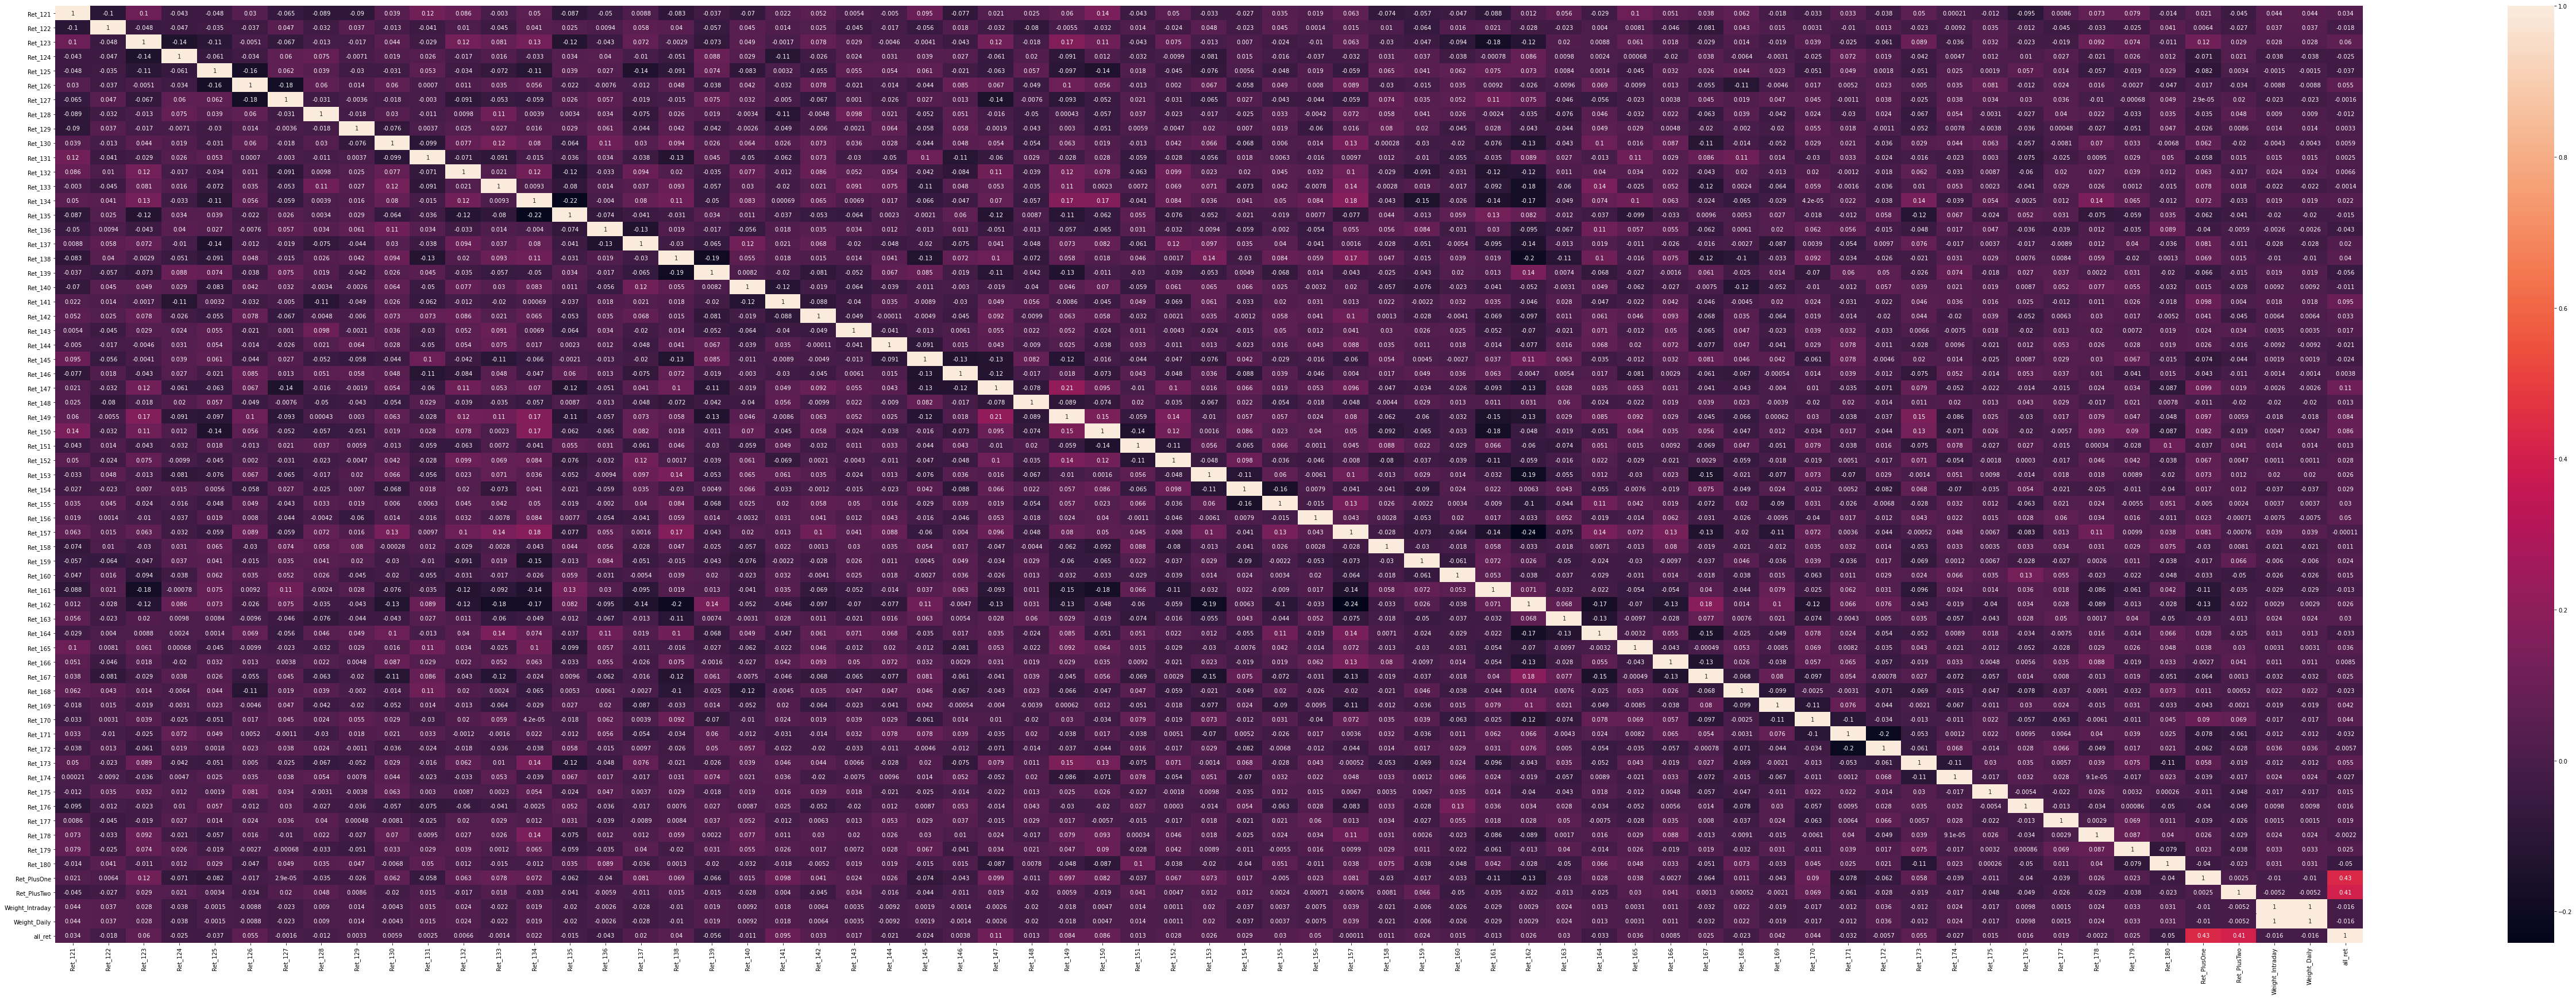

In [303]:
''' Plotting correlation with values '''
plt.figure(figsize = (90,30))
sns.heatmap(correlation, annot=True)
plt.show()

**Target variables are not correlated between them but are correlated with the sum of all return** 

**So they are not needed recursively to predict the target variables**

In [304]:
''' Getting correlation of next 2 days '''
Ret_next2 = df.corr()[['Ret_PlusTwo','Ret_PlusOne']]

In [305]:
''' Getting top and botton values of correlation of ret+1 '''
Ret_next2['Ret_PlusOne'].sort_values()

Ret_162       -0.126039
Ret_100       -0.108560
Ret_161       -0.105760
Ret_86        -0.089357
Ret_125       -0.082132
                 ...   
Ret_141        0.097669
Ret_147        0.098536
Ret_29         0.100272
Ret_123        0.118172
Ret_PlusOne    1.000000
Name: Ret_PlusOne, Length: 211, dtype: float64

In [306]:
''' Getting top and botton values of correlation of ret+2 '''
Ret_next2['Ret_PlusTwo'].sort_values()

Ret_3         -0.073488
Ret_94        -0.073271
Ret_171       -0.061091
Ret_106       -0.058274
Ret_30        -0.057091
                 ...   
Ret_7          0.054003
Ret_92         0.054474
Ret_159        0.066500
Ret_170        0.068715
Ret_PlusTwo    1.000000
Name: Ret_PlusTwo, Length: 211, dtype: float64

#### Imputing Missing Values

In [307]:
''' Populating ordinal columns(Probably rank columns) into a list '''
ordinal_columns = []
for i in range(1,26):
    col = 'Feature_'+str(i)
    distinct_count = len(df.eval(col).value_counts())
    print(col,' distinct values are ', distinct_count)
    if distinct_count < 11:
        ordinal_columns.append(col)

Feature_1  distinct values are  10
Feature_2  distinct values are  30854
Feature_3  distinct values are  38763
Feature_4  distinct values are  32279
Feature_5  distinct values are  10
Feature_6  distinct values are  38067
Feature_7  distinct values are  824
Feature_8  distinct values are  32
Feature_9  distinct values are  36
Feature_10  distinct values are  6
Feature_11  distinct values are  39013
Feature_12  distinct values are  101
Feature_13  distinct values are  10
Feature_14  distinct values are  39272
Feature_15  distinct values are  920
Feature_16  distinct values are  2
Feature_17  distinct values are  39354
Feature_18  distinct values are  39432
Feature_19  distinct values are  38810
Feature_20  distinct values are  9
Feature_21  distinct values are  38982
Feature_22  distinct values are  38655
Feature_23  distinct values are  38289
Feature_24  distinct values are  39274
Feature_25  distinct values are  39345


In [308]:
'''Filling the ordinal columns with 0 since it is rank values '''
for ord_col in ordinal_columns:
    df[ord_col] = df[ord_col].fillna(0)

In [309]:
''' Filling other feature columns with mean of the column '''

for feat_col in df.columns:
    if 'Feature_' in feat_col:
        df[feat_col] = df[feat_col].fillna(df[feat_col].mean())

In [310]:
''' Transposing columns with Ret_ as time series data is filled with (last_minute+next_minute)/2 value'''
transposed_return = df.filter(like='Ret_').T
transposed_return_filled = pd.concat([transposed_return.bfill(),transposed_return.ffill()]).groupby(level=0, sort=False).mean()
return_filled = transposed_return_filled.T

In [311]:
''' Seperating non return column without id column and joining it with filled value to form clean_df
    Scaling the feature columns as they have large integer values '''
clean_non_return_df = df.iloc[:,1:26].join( df.iloc[:,-2:])
#non_return_columns = non_return_df.columns
#scaled_non_return = preprocessing.StandardScaler().fit_transform(non_return_df)
#scaled_non_return_df = pd.DataFrame(data=scaled_non_return, columns= non_return_columns)
clean_df = clean_non_return_df.merge(return_filled,how = 'inner',left_index=True,right_index=True)
clean_df

Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0            0.0  -0.117558   0.558392   0.405572        8.0   0.430972   
1            0.0  -0.117558   0.558392   0.405572        3.0   0.388896   
2            0.0  -0.696727   0.739591  -0.167928        9.0   0.471947   
3            0.0  -0.694350   1.568248   0.479073        5.0   0.120653   
4            6.0  -1.736489   2.765531   1.245280        7.0   4.866985   
...          ...        ...        ...        ...        ...        ...   
39995        0.0  -0.117558   0.822371   0.405572        1.0   2.182050   
39996        0.0   0.747556  -0.489418  -0.267193       10.0  -0.454329   
39997        0.0  -0.117558  -0.914701  -1.013004        2.0  -0.701013   
39998        0.0  -0.021457   1.021284   0.405572        3.0   1.092849   
39999        0.0   1.093868  -0.677391  -0.604479        7.0   0.430972   

       Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0          75751     0.2254  11.000000         0.0   -0.572244        0.49   
1          17369     0.0166  13.000000         0.0   -0.409923        0.71   
2           8277     0.3650   9.000000         5.0   -0.473024        0.03   
3          22508     0.2654  13.000000         5.0   -2.138383        0.00   
4          22423     0.2138  13.000000         4.0   -4.795565        0.97   
...          ...        ...        ...         ...         ...         ...   
39995      23729     0.2208  12.000000         0.0   -0.605819        0.83   
39996      56222     0.2323   8.000000         5.0    0.264408        0.95   
39997       7024     0.3418  10.000000         5.0    1.041407        0.25   
39998      27376     0.2119  13.000000         0.0   -0.971196        0.97   
39999       4141     0.2254  10.680289         0.0    0.765670        0.63   

       ...   Ret_171   Ret_172   Ret_173   Ret_174   Ret_175   Ret_176  \
0      ...  0.001539 -0.000142  0.000861  0.000544 -0.002688  0.002246   
1      ... -0.000256 -0.000005 -0.000497  0.000240 -0.000129  0.000123   
2      ...  0.000656  0.000127  0.000255  0.000278 -0.000524 -0.000394   
3      ...  0.000371 -0.000055 -0.000161 -0.000155  0.000346 -0.000090   
4      ...  0.001214  0.001221 -0.000005 -0.000007 -0.001235  0.000027   
...    ...       ...       ...       ...       ...       ...       ...   
39995  ...  0.000614  0.000126 -0.000870  0.000617  0.000623  0.000504   
39996  ... -0.000011 -0.004517 -0.000009 -0.001304  0.000649  0.001290   
39997  ...  0.000384 -0.000586 -0.000773  0.000777  0.001375  0.000005   
39998  ... -0.000124  0.000522  0.000005  0.000127  0.000273  0.000017   
39999  ... -0.004096  0.004093  0.003651  0.000434 -0.000914 -0.002752   

            Ret_177       Ret_178   Ret_179   Ret_180  Ret_PlusOne  \
0     -8.384789e-04 -6.953224e-04  0.000003 -0.001974    -0.019512   
1      2.479729e-04  3.315418e-07  0.000003  0.000027    -0.002939   
2      1.162100e-04  5.322557e-04  0.000274  0.000784    -0.024791   
3      2.883115e-04 -1.281102e-04  0.000074  0.000341    -0.005680   
4      2.449409e-03  8.619882e-06  0.001209 -0.000004     0.036104   
...             ...           ...       ...       ...          ...   
39995  1.490012e-03  6.228587e-04 -0.000516 -0.000876    -0.024270   
39996 -6.031396e-07 -1.278452e-03 -0.000658  0.000628     0.017855   
39997  7.888841e-04  2.110042e-04 -0.000573 -0.001568     0.011602   
39998  2.471045e-04 -1.384585e-04  0.000015 -0.000123    -0.018877   
39999  1.350722e-03  9.032382e-04  0.003667  0.002761     0.024405   

       Ret_PlusTwo  
0         0.028846  
1        -0.010253  
2         0.015711  
3        -0.002190  
4        -0.026552  
...            ...  
39995     0.010143  
39996    -0.000094  
39997    -0.006539  
39998    -0.011572  
39999    -0.024345  

[40000 rows x 210 columns]

In [312]:
''' Seperate the data into train and test since last 62 columns are every minute returns and next 2 days returns 
    Feature selection using sklearn kbest method and dropping features with more than 20% missing values '''
X = clean_df.iloc[:,:-62]
x_dropped = X.drop(columns=['Feature_1', 'Feature_2','Feature_4','Feature_10','Feature_20','Weight_Daily','Weight_Intraday'])
y = clean_df.iloc[:,-62:]
x_train, x_test, y_train, y_test = train_test_split(x_dropped, y, test_size=0.1, shuffle=False)

In [313]:
x_train.shape

(36000, 141)

In [314]:
''' For each minute output column selected top 10 output column '''
index_list = []
for col in list(y_train.columns):
    best_x_train = SelectKBest(f_regression, k=10).fit(x_train, y_train[col])
    index = best_x_train.get_support(indices=True)
    index_list.extend(list(index))

In [315]:
''' Selecting top 20 features '''
count_dict = dict(Counter(index_list))
top_n_features_with_cnt = sorted(count_dict.items(), key=lambda x: x[1])[-20:]
top_n_features = set([i[0] for i in top_n_features_with_cnt])

In [316]:
x_train.iloc[:,list(top_n_features)]

Ret_108   Ret_109    Ret_76    Ret_82   Ret_118    Ret_87  \
0      1.666111e-04  0.000569 -0.003537 -0.000008 -0.000137  0.000005   
1     -7.091554e-07 -0.000240 -0.000740  0.000006 -0.000125  0.000001   
2      5.133768e-04  0.000393 -0.000386  0.000135 -0.000666  0.000256   
3     -4.162247e-04  0.000144  0.000281  0.000356 -0.000689 -0.000154   
4      2.430941e-03 -0.001192  0.000363 -0.000018 -0.000003  0.001203   
...             ...       ...       ...       ...       ...       ...   
35995  6.275674e-04  0.000317 -0.000622 -0.000010 -0.000621  0.000275   
35996  2.471486e-05  0.000101 -0.000001  0.000142 -0.000026 -0.000009   
35997 -3.406331e-04  0.001382  0.000007  0.000356  0.000006  0.000714   
35998 -1.485747e-05  0.000013  0.000007 -0.000002  0.000819 -0.000010   
35999 -1.798790e-03 -0.000600  0.000543  0.003170 -0.000603 -0.000597   

        Ret_119    Ret_57    Ret_58    Ret_56    Ret_91       Ret_120  \
0     -0.000009 -0.000212 -0.000432  0.000009  0.000003  1.340780e-04   
1     -0.000007 -0.000002  0.000445  0.000238 -0.000017  2.558108e-04   
2     -0.000270 -0.000003  0.000139 -0.000128  0.000143 -3.718829e-04   
3      0.000153  0.000038 -0.000127  0.000203  0.000074  2.220483e-04   
4      0.001208 -0.000240  0.000263  0.001219 -0.000007 -4.473375e-07   
...         ...       ...       ...       ...       ...           ...   
35995  0.000640  0.000005 -0.000014 -0.000312 -0.000014 -3.107102e-04   
35996 -0.000105 -0.000017 -0.000261  0.000123 -0.000019 -2.546221e-04   
35997  0.000364  0.001022  0.000010  0.000346 -0.000008 -6.879915e-04   
35998 -0.002444 -0.000008 -0.000424  0.000826  0.000001  8.156706e-04   
35999  0.000414 -0.000773 -0.001980  0.000791  0.000015  4.096843e-04   

        Ret_100    Ret_63    Ret_66        Ret_68   Ret_101   Ret_102  \
0     -0.000580  0.000435  0.000004 -1.065786e-05  0.000138 -0.002277   
1     -0.000003 -0.000002 -0.000243 -7.296493e-04 -0.000264 -0.000118   
2     -0.000134 -0.000139 -0.001057  6.601041e-04  0.000654 -0.000129   
3      0.000569  0.000083 -0.000369 -4.113614e-06 -0.000424  0.000138   
4      0.000009 -0.000361  0.001230 -7.070035e-06 -0.001201 -0.001196   
...         ...       ...       ...           ...       ...       ...   
35995 -0.000304  0.000629  0.000479  8.418574e-07  0.000621  0.001271   
35996  0.000194 -0.000005 -0.000514 -3.220094e-04 -0.000261 -0.000076   
35997 -0.000364 -0.000673 -0.000691  3.489976e-05  0.000683 -0.000005   
35998  0.000017  0.000002 -0.000001  5.433125e-06  0.000004 -0.000004   
35999 -0.000211  0.000980  0.000203  8.612023e-06  0.000393 -0.000213   

         Ret_71   Ret_104  
0     -0.002996  0.000406  
1      0.000363 -0.000377  
2     -0.000274  0.000271  
3      0.000105  0.000141  
4     -0.001233 -0.001214  
...         ...       ...  
35995 -0.000312 -0.000310  
35996  0.000454 -0.000361  
35997 -0.000691  0.000703  
35998 -0.000006  0.000016  
35999  0.001000  0.001572  

[36000 rows x 20 columns]

In [317]:
''' PCA on train data with 20 features '''
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
reduced_x = pca.fit_transform(x_train)


In [318]:
index_col = ['PC-'+str(i) for i in range(1,21)]
reduced_columns = pd.DataFrame(pca.components_.T,index=x_train.columns,columns= index_col)

In [319]:
pca.components_.T.shape

(141, 20)

In [320]:
reduced_columns

PC-1          PC-2          PC-3          PC-4  \
Feature_3 -8.940012e-09  2.172790e-03  1.535392e-01  1.534132e-01   
Feature_5 -1.554084e-09 -1.348263e-03 -4.841835e-01  8.152684e-01   
Feature_6 -3.392624e-07  6.088363e-03  2.558235e-01  7.092098e-02   
Feature_7  1.000000e+00  5.887798e-07  7.538248e-07  4.368857e-07   
Feature_8 -4.271551e-09 -3.309068e-04 -6.837077e-05 -3.596608e-04   
...                 ...           ...           ...           ...   
Ret_116    2.687751e-10 -2.031541e-07  1.346898e-06  1.651716e-06   
Ret_117   -1.584207e-10 -1.200266e-06 -2.224739e-06  3.668540e-07   
Ret_118   -2.987011e-10 -3.780482e-08 -3.327865e-07  2.280057e-06   
Ret_119   -2.063966e-11 -2.293966e-07 -3.551088e-06 -1.801204e-06   
Ret_120    6.555594e-10 -2.730107e-07 -8.581128e-07  4.731358e-06   

                   PC-5          PC-6          PC-7          PC-8  \
Feature_3 -2.281292e-02 -1.527434e-01 -1.256014e-01  1.667813e-01   
Feature_5 -2.141969e-01 -1.689452e-02  2.129791e-01 -8.071714e-02   
Feature_6  1.435691e-01 -2.513767e-01  4.379574e-01 -4.053198e-02   
Feature_7  2.633714e-07  7.512460e-08  1.373156e-07 -3.729249e-07   
Feature_8  3.347301e-04 -8.704869e-04  2.183326e-04 -6.081586e-04   
...                 ...           ...           ...           ...   
Ret_116    2.126202e-06  4.305662e-06 -1.655603e-05 -8.572008e-06   
Ret_117   -5.687905e-07  4.638997e-06  5.569003e-06 -1.062755e-05   
Ret_118   -1.531167e-06 -8.538133e-07 -1.617747e-06 -4.439789e-07   
Ret_119    2.458067e-06  3.511666e-06  2.063015e-06  3.289071e-06   
Ret_120    2.727966e-06 -1.146133e-06 -1.292506e-05 -6.808484e-06   

                   PC-9         PC-10         PC-11         PC-12  \
Feature_3  7.800592e-03  1.201786e-01  1.087686e-02  2.841597e-01   
Feature_5  8.493125e-03 -7.971892e-03 -1.400263e-02 -2.201545e-02   
Feature_6  2.703880e-01  4.492849e-01 -3.720358e-01 -3.052377e-01   
Feature_7  1.573707e-07 -3.102452e-08 -8.891534e-08  1.086549e-08   
Feature_8 -1.208639e-04  1.163112e-03 -1.750163e-03 -1.034863e-03   
...                 ...           ...           ...           ...   
Ret_116   -1.125764e-05  6.487962e-06 -1.193019e-05  1.244256e-05   
Ret_117    4.077395e-07  9.355509e-06  1.651931e-05  1.649008e-06   
Ret_118    3.347647e-07  2.320947e-06  8.450529e-06  1.429064e-06   
Ret_119   -8.805427e-06 -5.772930e-06 -1.176369e-05  1.008875e-05   
Ret_120    3.865458e-06  2.410922e-06  4.345883e-06 -2.446369e-06   

                  PC-13         PC-14         PC-15         PC-16  \
Feature_3 -4.638031e-02  1.373966e-01  1.614705e-02  2.313353e-02   
Feature_5 -1.028038e-02 -3.513459e-02 -2.836287e-03  2.404576e-02   
Feature_6  2.439845e-01  2.741041e-01  1.230691e-02 -1.018715e-01   
Feature_7  1.214420e-08 -1.646434e-07  1.194877e-07 -2.903749e-08   
Feature_8 -1.073264e-03 -3.457629e-03  2.820188e-03 -2.874978e-03   
...                 ...           ...           ...           ...   
Ret_116    1.561019e-05 -1.762328e-05 -4.309386e-05  1.872624e-05   
Ret_117   -6.483297e-06  7.576021e-05  8.353474e-06 -1.655788e-05   
Ret_118   -1.008047e-05  4.871907e-05 -2.850499e-05  4.786172e-05   
Ret_119   -1.936838e-05  1.412230e-05 -2.840593e-05  9.863491e-06   
Ret_120    3.172133e-05 -4.065092e-05 -7.922744e-06 -6.163697e-05   

                  PC-17         PC-18         PC-19         PC-20  
Feature_3 -5.902965e-01 -6.479107e-01 -1.531253e-03  2.299867e-03  
Feature_5  1.083805e-02  6.864750e-04  3.207828e-04 -1.577061e-04  
Feature_6 -2.246966e-03  2.216292e-02  6.586471e-04  8.368057e-04  
Feature_7  2.172595e-07 -1.116776e-07  1.762797e-09 -3.388323e-09  
Feature_8 -1.691886e-03 -3.009229e-03 -2.696829e-02 -9.996109e-01  
...                 ...           ...           ...           ...  
Ret_116   -5.594806e-05  1.356555e-05 -3.366941e-05  9.437163e-05  
Ret_117   -1.010890e-05 -6.291747e-06  9.597693e-05 -2.291504e-05  
Ret_118   -1.066345e-05 -2.753770e-05 -5.335230e-05  3.317045e-05  
Ret_119   -4.179791e-05

#### Autoencoder feature extraction

In [324]:

input_columns = 141
output_columns = 128,62,20
epoch = 10
input_data = keras.Input(shape=(input_columns,))
encoded_layer1 = layers.Dense(output_columns[0], activation='linear')(input_data)
encoded_layer2 = layers.Dense(output_columns[1], activation='linear')(encoded_layer1)
encoded_layer3 = layers.Dense(output_columns[2], activation='linear')(encoded_layer2)
decoded = layers.Dense(input_columns, activation='linear')(encoded_layer3)

In [325]:
autoencoder = keras.Model(input_data, decoded)
encoder = keras.Model(input_data, encoded_layer3)
encoded_input = keras.Input(shape=(output_columns[2],))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


In [326]:
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(x_train, x_train, epochs=epoch)

Epoch 1/10
36000/36000 [==============================] - 6s 165us/step - loss: 358.2735
Epoch 2/10
36000/36000 [==============================] - 3s 88us/step - loss: 29.2600
Epoch 3/10
36000/36000 [==============================] - 3s 75us/step - loss: 24.0405
Epoch 4/10
36000/36000 [==============================] - 3s 75us/step - loss: 21.1337
Epoch 5/10
36000/36000 [==============================] - 3s 74us/step - loss: 19.3705
Epoch 6/10
36000/36000 [==============================] - 3s 75us/step - loss: 17.1384
Epoch 7/10
36000/36000 [==============================] - 3s 76us/step - loss: 15.3821
Epoch 8/10
36000/36000 [==============================] - 3s 78us/step - loss: 13.9492
Epoch 9/10
36000/36000 [==============================] - 3s 76us/step - loss: 12.3413
Epoch 10/10
36000/36000 [==============================] - 3s 82us/step - loss: 11.3324


In [327]:
encoded_data = encoder.predict(x_train)
encoded_df = pd.DataFrame(data=encoded_data)
encoded_df

0          1           2          3           4           5  \
0     -115.805290  22.660313  538.689941  23.781111 -731.302185  147.076614   
1      -23.391111   8.906987  125.519310   4.571368 -166.844940   32.660034   
2       -9.715733   7.045191   61.849899   0.651152  -79.193169   14.298293   
3      -30.728230  10.755923  161.356796   5.593355 -216.377823   42.314117   
4      -29.655195   7.826354  160.019272   5.709168 -215.550201   41.434528   
...           ...        ...         ...        ...         ...         ...   
35995  -75.962860  16.249794  354.739685  15.148737 -482.727875   96.465744   
35996  -19.554941   9.633124  116.588135   2.616025 -154.245483   29.855314   
35997   -4.882370   6.013998   52.131973  -1.293782  -63.263187    9.843798   
35998 -153.133713  28.439867  691.045410  33.712509 -944.317444  192.087372   
35999  -39.722767  10.574244  186.756119   8.428720 -253.556183   50.432800   

                  6             7            8           9           10  \
0     -20902.212891  20951.603516  7307.645996  -95.580070  7305.859863   
1      -4792.945801   4804.323242  1676.687134  -21.680403  1675.500122   
2      -2283.846191   2289.666992   799.714722   -9.289817   799.017517   
3      -6211.029785   6226.761230  2172.655518  -27.240520  2170.957520   
4      -6187.291504   6202.301758  2164.599365  -28.267746  2163.740723   
...             ...           ...          ...         ...          ...   
35995 -13795.308594  13828.674805  4823.050293  -62.859505  4822.160645   
35996  -4451.111816   4463.063477  1557.961670  -18.205814  1555.627075   
35997  -1840.462280   1843.270386   644.786804   -8.592752   644.743225   
35998 -26985.457031  27052.396484  9433.525391 -121.025833  9430.822266   
35999  -7239.616211   7258.213379  2531.638428  -32.352161  2530.568115   

              11          12        13         14           15          16  \
0     -32.990189  151.789429  6.500837  18.762268  1276.509644 -317.941010   
1      -6.430356   35.043522  3.523877   3.986598   292.045135  -72.105827   
2      -1.206056   17.009542  2.331994   0.428062   138.374756  -33.594433   
3      -7.440893   45.006592  4.786971   5.562076   379.105713  -93.451195   
4      -8.486881   44.869656  3.710994   4.526122   377.600739  -93.593010   
...          ...         ...       ...        ...          ...         ...   
35995 -21.562864  100.023232  4.617712  12.431856   842.873413 -209.579132   
35996  -3.752102   31.715227  5.189931   3.791165   271.055481  -66.001030   
35997   0.468339   14.772766  1.293785  -0.607408   110.823708  -26.681978   
35998 -43.795444  194.021759  9.587996  26.433029  1650.250977 -410.785248   
35999 -11.445253   52.611008  3.664931   6.364181   442.142426 -109.762688   

              17            18           19  
0     -60.560631 -16315.660156 -3391.267090  
1     -14.175927  -3740.460693  -778.194763  
2      -6.286728  -1782.228516  -370.710907  
3     -17.726570  -4848.395508 -1007.742249  
4     -18.200508  -4831.085938 -1004.615295  
...          ...           ...          ...  
35995 -39.390709 -10768.333008 -2237.878662  
35996 -12.387826  -3475.293701  -722.271729  
35997  -5.502648  -1435.805176  -299.043243  
35998 -77.180077 -21065.318359 -4377.389160  
35999 -20.836662  -5650.829590 -1174.593384  

[36000 rows x 20 columns]

In [328]:
decoded_data = decoder.predict(encoded_data)
decoded_df = pd.DataFrame(data=decoded_data)
decoded_df

0          1         2             3          4         5    \
0      7.070617  -7.752291 -6.779130  74737.023438 -11.679627 -1.625573   
1      1.826050  -0.167045 -1.405650  17137.339844  -2.555929  2.105267   
2      1.087396   1.165028 -0.595082   8166.096680  -1.193840  2.775329   
3      2.255030  -0.868170 -1.823745  22207.683594  -3.402113  1.887936   
4      2.329667  -0.847090 -1.923764  22125.941406  -3.404715  1.899607   
...         ...        ...       ...           ...        ...       ...   
35995  4.720092  -4.556846 -4.412495  49325.992188  -7.644002 -0.016384   
35996  1.674608  -0.023783 -1.171958  15914.448242  -2.483203  2.355602   
35997  1.098436   1.590714 -0.613405   6579.915527  -1.002942  3.160778   
35998  8.715145 -11.119096 -8.501165  96488.179688 -15.022354 -3.376893   
35999  2.568805  -1.439896 -2.195196  25887.414062  -3.903885  1.375640   

             6         7         8         9         10        11   ...  \
0      14.651247 -6.871006  2.844236 -0.247755  1.577415 -0.432849  ...   
1       3.109514 -1.384600  1.776714  0.605591  1.213507  0.432569  ...   
2       1.167883 -0.550164  1.648542  0.920443  1.265289  0.576449  ...   
3       4.121983 -1.960798  1.798415  0.522959  1.100648  0.288329  ...   
4       4.037239 -1.833734  1.707832  0.530435  1.126888  0.361464  ...   
...          ...       ...       ...       ...       ...       ...  ...   
35995   9.671410 -4.478956  2.244314 -0.042596  1.185107 -0.135486  ...   
35996   2.786366 -1.447224  1.687368  0.742717  1.049097  0.338235  ...   
35997   0.649810 -0.368343  1.587574  1.230219  1.539565  0.807945  ...   
35998  19.445078 -9.074643  3.134728 -1.217503  1.009286 -1.174061  ...   
35999   4.991014 -2.200468  1.904382  0.277110  1.064969  0.193370  ...   

            129        130       131        132        133       134  \
0     -6.887733 -31.182880 -3.375825  14.816501 -24.822170  0.369989   
1     -1.538791  -7.140084 -0.737382   3.392234  -5.632444  0.042618   
2     -0.651792  -3.445808 -0.383415   1.606010  -2.719652  0.048219   
3     -2.007093  -9.216833 -0.953198   4.309814  -7.358106  0.075595   
4     -1.994048  -9.223308 -0.933875   4.217799  -7.336449  0.089287   
...         ...        ...       ...        ...        ...       ...   
35995 -4.592709 -20.431549 -2.147389   9.666463 -16.363255  0.196734   
35996 -1.407116  -6.673829 -0.713080   3.071239  -5.290342  0.050649   
35997 -0.426158  -3.020078 -0.340395   1.341439  -2.281296  0.083684   
35998 -9.044367 -39.800785 -4.236653  18.969879 -31.945808  0.396508   
35999 -2.400537 -10.583136 -1.101857   5.027312  -8.508888  0.083947   

             135        136        137       138        139       140  
0      14.334815 -12.292528  30.761950  5.210911  14.942133 -4.573037  
1       3.290329  -2.786436   7.106562  1.121415   3.355937 -1.027637  
2       1.549906  -1.236065   3.395349  0.419157   1.516311 -0.465778  
3       4.237627  -3.618766   9.294595  1.572480   4.414872 -1.331876  
4       4.214567  -3.740093   9.395823  1.581133   4.500500 -1.430992  
...          ...        ...        ...       ...        ...       ...  
35995   9.488644  -8.167543  20.447472  3.582267   9.919193 -3.012790  
35996   2.973556  -2.556460   6.708395  1.070385   3.158766 -0.912865  
35997   1.205689  -1.002498   2.671260  0.256406   1.205867 -0.484013  
35998  18.576187 -15.928268  39.982368  7.044655  19.412304 -5.797505  
35999   5.013443  -4.233994  10.771157  1.827126   5.135815 -1.525472  

[36000 rows x 141 columns]

#### Baseline model (Median of target variables)

In [329]:
target_median_list = [y[i].median() for i in y.columns]

In [330]:
''' Storing median list as pickle file '''
import pickle 
file = open('target_median_list.pkl','wb')
pickle.dump(target_median_list,file)
file.close()

In [331]:
'''  Creating dataframe with Id and Predicted column '''
submission_file_df = pd.DataFrame(columns=['Id','Predicted'])

In [332]:
test_df = pd.read_csv(r'C:\Users\thiyagarajan\Downloads\aaic\case_study1\data\winton_stock\test\test_2.csv')

In [333]:
len(test_df)

120000

In [334]:
''' Creating Id column with list comprehension '''
id_lst = [str(i)+'_'+str(j) for i in range(1,len(test_df)+1) for j in range(1,63)]

In [335]:
len(id_lst)

7440000

In [336]:
submission_file_df['Id'] = id_lst

In [337]:
''' Creating Predicted value with target_median_list times length of test_df '''
submission_file_df['Predicted'] = target_median_list * len(test_df)

In [338]:
''' Checking if 3rd row equals 127 row (62*2 + 3)'''
submission_file_df.iloc[127] == submission_file_df.iloc[3]

Id           False
Predicted     True
dtype: bool

In [339]:
'''  Writing to zip file and csv file '''
submission_file_df.to_csv(r'C:/Users/thiyagarajan/Downloads/aaic/case_study1/data/winton_stock/sample_submission/baseline_median_model.csv.zip',index=False, compression='zip')
submission_file_df.to_csv(r'C:/Users/thiyagarajan/Downloads/aaic/case_study1/data/winton_stock/sample_submission/baseline_median_model.csv',index=False)

In [340]:
''' Reading sample file and baseline file'''
sample_sub_base = pd.read_csv(r'C:/Users/thiyagarajan/Downloads/aaic/case_study1/data/winton_stock/sample_submission/baseline_median_model.csv.zip')
sample_sub1 = pd.read_csv(r'C:/Users/thiyagarajan/Downloads/aaic/case_study1/data/winton_stock/sample_submission/sample_submission_2.csv')

In [341]:
''' Id column matches on both the dataframes '''
sample_sub1['Id'].equals(sample_sub_base['Id'])

True

In [342]:
''' Last few records of baseline model '''
sample_sub_base.tail()

Id     Predicted
7439995  120000_58  6.407432e-07
7439996  120000_59  1.040598e-06
7439997  120000_60 -1.677217e-06
7439998  120000_61 -2.584837e-04
7439999  120000_62 -2.582153e-04

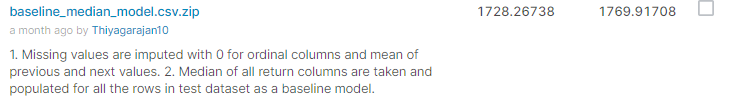

#### Conclusions from EDA, FE, Baseline models

**EDA**
1. All the rows do not follow a similar pattern.
2. Daily and Hourly returns are not similar and must be evaluated seperately.
3. Target variables are not co-related so recursive prediction of target variables is not required.
4. Return varaiables are important than feature variables in terms of predicting output.

**FE**
1. Autoencoder with 20 target output variables are created and can be used for predicting output values.
2. SelectKBest from sklearn is used with f_regression to predict top 20 input columns.

**Baseline Model**
- Created baseline model with median of all output variables from train data and populated it for all rows for test data and submitted it in kaggle and got 1769.917 score and 152nd rank in private leaderboard and 262nd rank in public leaderboard while 0 prediction is at 372nd rank in private leaderboard

**Modelling**

In [343]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error

In [344]:
score_dict = {}

In [345]:
y_train.shape

(36000, 62)

In [346]:
sgdreg = SGDRegressor()
params = {   'estimator__loss' : ['squared_loss'],
            'estimator__penalty' : [ 'l2', 'l1', 'elasticnet'],
            'estimator__eta0' : [0.0001, 0.001, 0.01, 0.1, 0.5],
           'estimator__alpha' : [0.000001,0.00001, 0.0001, 0.001],
          'estimator__learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']
          }
search_cv = RandomizedSearchCV(MultiOutputRegressor(sgdreg), param_distributions= params,  n_jobs=-1)
search_cv.fit(x_train[:100],y_train[:100])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=SGDRegressor(alpha=0.0001,
                                                                         average=False,
                                                                         early_stopping=False,
                                                                         epsilon=0.1,
                                                                         eta0=0.01,
                                                                         fit_intercept=True,
                                                                         l1_ratio=0.15,
                                                                         learning_rate='invscaling',
                                                                         loss='squared_loss',
                                                                         max_iter=1000,
                                 

In [347]:
best_param_sgd = search_cv.best_params_
best_sgd = MultiOutputRegressor(SGDRegressor(alpha = best_param_sgd['estimator__alpha'], loss = best_param_sgd['estimator__loss'],
                              penalty = best_param_sgd['estimator__penalty'], learning_rate = best_param_sgd['estimator__learning_rate'],
                                       eta0 = best_param_sgd['estimator__eta0']))
best_sgd.fit(x_train[:1000], y_train[:1000])

MultiOutputRegressor(estimator=SGDRegressor(alpha=1e-06, average=False,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.001, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='adaptive',
                                            loss='squared_loss', max_iter=1000,
                                            n_iter_no_change=5, penalty='l1',
                                            power_t=0.25, random_state=None,
                                            shuffle=True, tol=0.001,
                                            validation_fraction=0.1, verbose=0,
                                            warm_start=False),
                     n_jobs=None)

In [348]:
pred_y = best_sgd.predict(x_test)

In [349]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['SGD_Linear_reg'] = diff 
diff 

561528643262651.1

In [350]:
best_linear = LinearRegression()
best_linear.fit(x_train, y_train)
pred_y = best_linear.predict(x_test)

In [351]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['LinearRegression'] = diff
diff

0.0011294620658400887

In [352]:
params = { 'estimator__kernel' : [ 'poly', 'rbf','linear']
           ,'estimator__C' : [0.1,1]
           ,'estimator__gamma' : ['auto']
           ,'estimator__epsilon' : [0.1,1,10]
          }
clf = SVR()
search_cv = RandomizedSearchCV(MultiOutputRegressor(clf), param_distributions= params,n_iter=10, n_jobs=-1)
#search_cv.fit(x_train,y_train)

In [353]:
search_cv.fit(x_train[:100],y_train[:100])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=SVR(C=1.0,
                                                                cache_size=200,
                                                                coef0=0.0,
                                                                degree=3,
                                                                epsilon=0.1,
                                                                gamma='auto_deprecated',
                                                                kernel='rbf',
                                                                max_iter=-1,
                                                                shrinking=True,
                                                                tol=0.001,
                                                                verbose=False),
                                                  n_jobs=None),
                 

In [354]:
best_param = {k:[v] for k,v in search_cv.best_params_.items()}
best_svr = RandomizedSearchCV(MultiOutputRegressor(clf), param_distributions= best_param, n_iter=1, n_jobs=-1)
best_svr.fit(x_train[:100],y_train[:100])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=SVR(C=1.0,
                                                                cache_size=200,
                                                                coef0=0.0,
                                                                degree=3,
                                                                epsilon=0.1,
                                                                gamma='auto_deprecated',
                                                                kernel='rbf',
                                                                max_iter=-1,
                                                                shrinking=True,
                                                                tol=0.001,
                                                                verbose=False),
                                                  n_jobs=None),
                 

In [355]:
pred_y = best_svr.predict(x_test)

In [356]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['SupportVectorRegression'] = diff
diff

0.002168876465056322

In [357]:
from sklearn.neighbors import KNeighborsRegressor

In [358]:
nn = KNeighborsRegressor()
params = { 'n_neighbors' : [ 1,3,5,7,9,11,13]
           ,'algorithm' : ['ball_tree','kd_tree','auto']
          }
search_nn = RandomizedSearchCV(nn, param_distributions= params, n_iter=10, n_jobs=-1)
search_nn.fit(x_train,y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'auto'],
                                        'n_neighbors': [1, 3, 5, 7, 9, 11, 13]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [359]:
best_param_nn = search_nn.best_params_
best_nn = KNeighborsRegressor(n_neighbors = best_param_nn['n_neighbors'], algorithm = best_param_nn['algorithm'])
best_nn.fit(x_train,y_train)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                    weights='uniform')

In [360]:
pred_y = best_nn.predict(x_test)

In [361]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['KNeighborsRegressor'] = diff
diff

0.0009673696070506833

In [362]:
from sklearn.tree import DecisionTreeRegressor
params = {'criterion' : ['mse', 'mae'],
          'max_depth' : [2,5,10],
          'min_samples_split' : [0.1, 0.3, 0.5, 0.7, 0.9] }
dtreg = DecisionTreeRegressor()
search_cv = RandomizedSearchCV(dtreg, param_distributions= params, n_iter=10, n_jobs=-1)
search_cv.fit(x_train[:100], y_train[:100])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param

In [363]:
best_param = search_cv.best_params_
best_dt = DecisionTreeRegressor(criterion = best_param['criterion'], max_depth = best_param['max_depth'],
                              min_samples_split = best_param['min_samples_split'])
best_dt.fit(x_train[:1000], y_train[:1000])

DecisionTreeRegressor(criterion='mae', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=0.1, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [364]:
pred_y = best_dt.predict(x_test)


In [365]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['DecisionTree'] = diff
diff

0.0011148312250624393

In [366]:
from sklearn.ensemble import RandomForestRegressor
params = { 'n_estimators' : [ 10,50,100,150]
           ,'criterion' : ['mse','mae']
          ,'max_leaf_nodes' : [ 5, 10, 15]
          ,'n_jobs' : [-1]
          ,'warm_start' : [True]
          }
rfreg = RandomForestRegressor()
search_cv = RandomizedSearchCV(rfreg, param_distributions= params, n_iter=10, n_jobs=-1)
search_cv.fit(x_train[:10], y_train[:10])


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st

In [367]:
best_param_rf = search_cv.best_params_
best_rfreg = RandomForestRegressor(n_estimators = best_param_rf['n_estimators'], criterion = best_param_rf['criterion'],
                              max_leaf_nodes = best_param_rf['max_leaf_nodes'], n_jobs = best_param_rf['n_jobs'],
                               warm_start = best_param_rf['warm_start'])
best_rfreg.fit(x_train[:100], y_train[:100])

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=15,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=True)

In [368]:
pred_y = best_rfreg.predict(x_test)

In [369]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['RandomForestRegressor'] = diff
diff

0.0011867816933056371

In [370]:
import xgboost as xgb

In [371]:
clf = xgb.XGBRegressor()
param = {'estimator__n_estimators' : [10,50,100,200]
         ,'estimator__eta' : [0.1,0.3,0.5,1]
         ,'estimator__gamma' : [0,3,5,10]
         ,'estimator__max_depth' : [2,5,10,15]}
search_xgb = RandomizedSearchCV(MultiOutputRegressor(clf), param_distributions= param,n_iter=10, n_jobs=-1)


In [372]:
#xgbregressor = MultiOutputRegressor(xgb.XGBRegressor( n_estimators=100,max_depth=3))
search_xgb.fit(x_train[:100], y_train[:100])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         gamma=None,
                                                                         gpu_id=None,
                                                                         importance_type='gain',
                                                                         interaction_constraints=None,
                                                                         learning_rate=None,
       

In [373]:
best_param_xgb = search_xgb.best_params_
best_xgb = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=best_param_xgb['estimator__n_estimators']
         ,eta=best_param_xgb['estimator__eta']
         ,gamma=best_param_xgb['estimator__gamma']
         ,max_depth=best_param_xgb['estimator__max_depth']    ))
best_xgb.fit(x_train[:1000],y_train[:1000])

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, eta=0.1,
                                            gamma=5, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squarederr

In [374]:
pred_y = best_xgb.predict(x_test)

In [375]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['XGBRegressor'] = diff
diff

0.00110974061074398

In [376]:
import pickle
pickle.dump(best_xgb, open('py_files/xgb_model.pkl','wb') )

In [377]:
score_dict

{'DecisionTree': 0.0011148312250624393,
 'KNeighborsRegressor': 0.0009673696070506833,
 'LinearRegression': 0.0011294620658400887,
 'RandomForestRegressor': 0.0011867816933056371,
 'SGD_Linear_reg': 561528643262651.1,
 'SupportVectorRegression': 0.002168876465056322,
 'XGBRegressor': 0.00110974061074398}

In [378]:
from sklearn.ensemble import AdaBoostRegressor
best_adaboost = MultiOutputRegressor(AdaBoostRegressor(base_estimator=xgb.XGBRegressor(n_estimators=best_param_xgb['estimator__n_estimators']
         ,eta=best_param_xgb['estimator__eta']
         ,gamma=best_param_xgb['estimator__gamma']
         ,max_depth=best_param_xgb['estimator__max_depth'] )))
best_adaboost.fit(x_train[:1000], y_train[:1000])

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=XGBRegressor(base_score=None,
                                                                             booster=None,
                                                                             colsample_bylevel=None,
                                                                             colsample_bynode=None,
                                                                             colsample_bytree=None,
                                                                             eta=0.1,
                                                                             gamma=5,
                                                                             gpu_id=None,
                                                                             importance_type='gain',
                                                                             interaction_constraints=None,
                                            

In [379]:
pred_y = best_adaboost.predict(x_test)

In [380]:
diff = mean_absolute_error(y_test, pred_y)
score_dict['AdaBoost'] = diff
diff

0.0011440812886902105

In [381]:
from mlxtend.regressor import StackingCVRegressor
best_stack= MultiOutputRegressor(StackingCVRegressor(regressors=(KNeighborsRegressor(n_neighbors = best_param_nn['n_neighbors'], algorithm = best_param_nn['algorithm'])
                                                            ,
                                xgb.XGBRegressor(n_estimators=best_param_xgb['estimator__n_estimators']
         ,eta=best_param_xgb['estimator__eta']
         ,gamma=best_param_xgb['estimator__gamma']
         ,max_depth=best_param_xgb['estimator__max_depth']) )
                               , meta_regressor=RandomForestRegressor(n_estimators = best_param_rf['n_estimators'], criterion = best_param_rf['criterion'],
                              max_leaf_nodes = best_param_rf['max_leaf_nodes'], n_jobs = best_param_rf['n_jobs'], warm_start = best_param_rf['warm_start'])
                                                
                                ,n_jobs=-1, refit=False))
best_stack.fit(x_train[:100], y_train[:100])

MultiOutputRegressor(estimator=StackingCVRegressor(cv=5,
                                                   meta_regressor=RandomForestRegressor(bootstrap=True,
                                                                                        criterion='mae',
                                                                                        max_depth=None,
                                                                                        max_features='auto',
                                                                                        max_leaf_nodes=15,
                                                                                        min_impurity_decrease=0.0,
                                                                                        min_impurity_split=None,
                                                                                        min_samples_leaf=1,
                                                                              

In [382]:
pred_y = best_stack.predict(x_test)
diff = mean_absolute_error(y_test, pred_y)
score_dict['StackingCVRegressor'] = diff
diff

0.0012420194058742945

In [383]:
from keras.models import Sequential
model = Sequential()
x_train.shape

(36000, 141)

In [384]:

input_columns = 141
output_columns = 130,80,120,90,100,80,62
epoch = 10
input_data = keras.Input(shape=(input_columns,))
layer1 = layers.Dense(output_columns[0], activation='linear')(input_data)
layer2 = layers.Dense(output_columns[1], activation='linear')(layer1)
layer3 = layers.Dense(output_columns[2], activation='linear')(layer2)
layer4 = layers.Dense(output_columns[3], activation='tanh')(layer3)
layer5 = layers.Dense(output_columns[4], activation='linear')(layer4)
layer6 = layers.Dense(output_columns[5], activation='linear')(layer5)
layer7 = layers.Dense(output_columns[6], activation='linear')(layer6)

In [385]:
best_neural = keras.Model(input_data, layer7)
best_neural.compile(optimizer='adam', loss='mae')
best_neural.fit(x_train, y_train, epochs=10)

Epoch 1/10
36000/36000 [==============================] - 6s 172us/step - loss: 0.0249
Epoch 2/10
36000/36000 [==============================] - 3s 92us/step - loss: 0.0061
Epoch 3/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0029
Epoch 4/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0017
Epoch 5/10
36000/36000 [==============================] - 4s 99us/step - loss: 0.0013
Epoch 6/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0012
Epoch 7/10
36000/36000 [==============================] - 3s 95us/step - loss: 0.0014
Epoch 8/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0013
Epoch 9/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0019
Epoch 10/10
36000/36000 [==============================] - 3s 93us/step - loss: 0.0012


In [386]:
pred_y = best_neural.predict(x_test)
diff = mean_absolute_error(y_test, pred_y)
score_dict['MLP'] = diff
diff

0.0011475436253147989

In [387]:
score_dict

{'AdaBoost': 0.0011440812886902105,
 'DecisionTree': 0.0011148312250624393,
 'KNeighborsRegressor': 0.0009673696070506833,
 'LinearRegression': 0.0011294620658400887,
 'MLP': 0.0011475436253147989,
 'RandomForestRegressor': 0.0011867816933056371,
 'SGD_Linear_reg': 561528643262651.1,
 'StackingCVRegressor': 0.0012420194058742945,
 'SupportVectorRegression': 0.002168876465056322,
 'XGBRegressor': 0.00110974061074398}

**We will use all the models to predict test dataset**

In [388]:
'''Filling the ordinal columns with 0 since it is rank values '''
for ord_col in ordinal_columns:
    test_df[ord_col] = test_df[ord_col].fillna(0)
''' Filling other feature columns with mean of the column '''
for feat_col in test_df.columns:
    if 'Feature_' in feat_col:
        test_df[feat_col] = test_df[feat_col].fillna(test_df[feat_col].mean())
''' Transposing columns with Ret_ as time series data is filled with (last_minute+next_minute)/2 value'''
transposed_return = test_df.filter(like='Ret_').T
transposed_return_filled = pd.concat([transposed_return.bfill(),transposed_return.ffill()]).groupby(level=0, sort=False).mean()
return_filled = transposed_return_filled.T
''' Seperating non return column without id column and joining it with filled value to form clean_test_df
    Scaling the feature columns as they have large integer values '''
clean_non_return_test_df = test_df.iloc[:,1:26]
clean_test_df = clean_non_return_test_df.merge(return_filled,how = 'inner',left_index=True,right_index=True)
test_clean = clean_test_df.drop(columns=['Feature_1', 'Feature_2','Feature_4','Feature_10','Feature_20'])
test_clean

Feature_3  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9  \
0       -0.056284       10.0   0.413226      18871     0.2138  11.000000   
1        0.907973        7.0  -0.257825       5852     0.2138  13.000000   
2        1.076668        5.0   0.947340      76935     0.0105  10.000000   
3        0.223222        1.0   0.439345      84573     0.3318  13.000000   
4        0.597896       10.0   0.275744      89615     0.0099   8.000000   
...           ...        ...        ...        ...        ...        ...   
119995   0.254581        4.0   0.555200      83607     0.0105  10.698733   
119996   0.326614        2.0  -0.380763      73541     0.3650  13.000000   
119997   0.866862        9.0  -0.223997      22982     0.2323   9.000000   
119998   1.511941        7.0   1.234636      73343     0.2138  12.000000   
119999   0.119261        1.0   1.265873      48516     0.2323   9.000000   

        Feature_11  Feature_12  Feature_13  Feature_14  Feature_15  \
0        -0.229910        0.97         8.0    1.683134   12.513327   
1        -0.971909        0.93         4.0    1.395301   13.225147   
2        -1.096276        0.88         4.0    1.722474    0.227258   
3        -0.509942        0.76         5.0    1.805385    0.632670   
4        -1.188949        0.64         4.0    1.528518    0.742222   
...            ...         ...         ...         ...         ...   
119995    0.080069        0.37         4.0    1.531995    0.024679   
119996    0.375793        0.44         6.0    1.638717    2.500059   
119997   -1.108936        0.73         0.0    1.616769    2.359433   
119998   -1.278984        0.24         6.0    1.752634   16.758902   
119999    0.346361        0.12         0.0    1.313645    6.655056   

        Feature_16  ...   Ret_109   Ret_110   Ret_111   Ret_112   Ret_113  \
0              1.0  ...  0.000088  0.000088  0.000370 -0.000762 -0.000198   
1              1.0  ...  0.000437 -0.000016  0.000457  0.000003 -0.000007   
2              1.0  ...  0.000193 -0.000343  0.000003  0.000157 -0.000181   
3              1.0  ...  0.000000  0.000467  0.000010 -0.000792 -0.000479   
4              1.0  ... -0.000010 -0.000197  0.000447  0.000489 -0.000233   
...            ...  ...       ...       ...       ...       ...       ...   
119995         1.0  ...  0.000018 -0.000283 -0.000152  0.003157  0.001920   
119996         1.0  ...  0.000632  0.000208 -0.000614 -0.000408 -0.000192   
119997         1.0  ...  0.001110 -0.000038 -0.001052  0.000458  0.000450   
119998         1.0  ...  0.000315 -0.001086  0.000783 -0.000627 -0.000170   
119999         1.0  ... -0.000498 -0.000967 -0.001459 -0.001445 -0.000226   

         Ret_114   Ret_115   Ret_116   Ret_117   Ret_118   Ret_119   Ret_120  
0       0.000366 -0.002444 -0.001301 -0.000917  0.000762 -0.000556  0.000759  
1      -0.000003 -0.000012 -0.000463 -0.000003 -0.000002  0.000468 -0.000012  
2       0.000003  0.000083  0.000164  0.000353  0.000704 -0.000168 -0.000006  
3       0.000017  0.000170 -0.001079  0.000320  0.000006  0.001392 -0.001850  
4      -0.000495  0.000057 -0.000050 -0.000011 -0.000377  0.000227 -0.000114  
...          ...       ...       ...       ...       ...       ...       ...  
119995 -0.001893 -0.001358 -0.000820 -0.002989  0.001091 -0.001365  0.001637  
119996 -0.000612 -0.000008  0.000408  0.000014 -0.000583 -0.000012  0.000426  
119997 -0.000219 -0.000675 -0.001202  0.000116  0.000885 -0.000424 -0.000892  
119998  0.000463  0.000008  0.000155 -0.000479  0.000781  0.000494  0.000005  
119999 -0.000235 -0.000484 -0.000961 -0.002417 -0.000973  0.002880  0.002204  

[120000 rows x 141 columns]

In [389]:
import pickle
ordinal_col_fill = 0
feature_col_fill = test_df[feat_col].mean()
pickle.dump(feature_col_fill, open('py_files/feat_col_fill.pkl', 'wb'))

In [390]:
a = pickle.load(open('py_files/feat_col_fill.pkl','rb'))
a

-2.4379553146387942e-06

In [391]:
[i for i in list(x_train.columns) if i not in  list(test_clean.columns) ]

[]

**So train and test datasets have same column**

In [392]:
id_lst = [str(i)+'_'+str(j) for i in range(1,len(test_df)+1) for j in range(1,63)]

In [393]:
def create_submission_file(model,file_name):
    test_pred_y = model.predict(test_clean)
    flattened = test_pred_y.flatten()
    submission_sgd = pd.DataFrame(columns=['Id','Predicted'])
    submission_sgd['Id'] = id_lst
    submission_sgd['Predicted'] = flattened
    submission_sgd.to_csv(r'C:/Users/thiyagarajan/Downloads/aaic/case_study1/data/winton_stock/sample_submission/' + file_name + '_model.csv.zip',index=False, compression='zip')

In [394]:
create_submission_file(best_sgd, 'sgd')

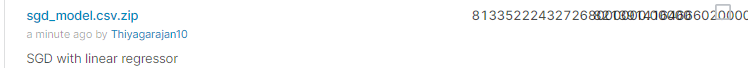

In [395]:
create_submission_file(best_linear,'linear')

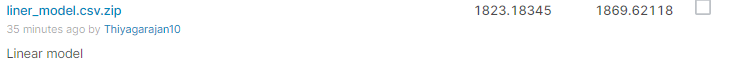

In [396]:
create_submission_file(best_svr,'svr')

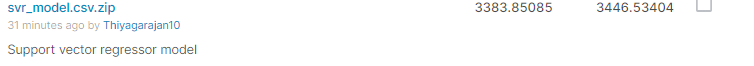

In [397]:
create_submission_file(best_nn,'nn')


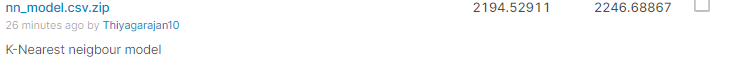

In [398]:
create_submission_file(best_dt,'dt')


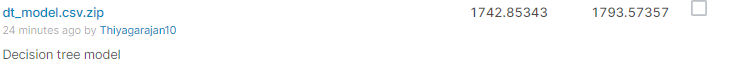

In [399]:
create_submission_file(best_rfreg,'randomforest')


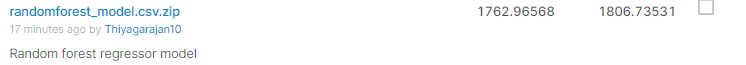

In [400]:
create_submission_file(best_xgb,'xgb')


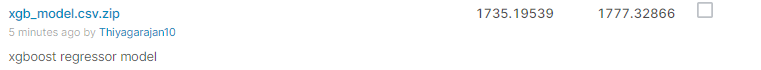

In [401]:
create_submission_file(best_adaboost,'adaboost')


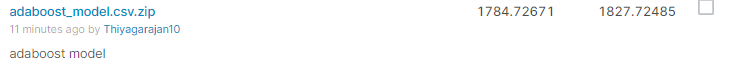

In [403]:
create_submission_file(best_stack,'stacking')


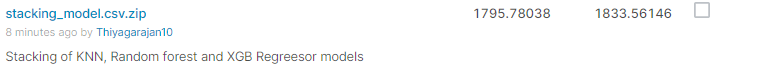

In [404]:
create_submission_file(best_neural,'mlp')

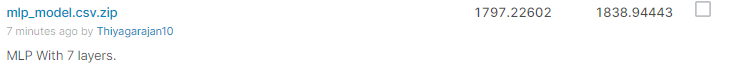

**From all the models XGBoost performs better and is near to he baseline median prediction model** 

In [405]:
import io
def final_fun_1(X):
    ''' Final function 1 to get the input data and predict the y values'''
    x_df = pd.read_csv(io.StringIO(X), names=test_df.columns)
    
    for ord_col in ordinal_columns:
        x_df[ord_col] = x_df[ord_col].fillna(ordinal_col_fill)
    
    for feat_col in x_df:
        if 'Feature_' or 'Ret_' in feat_col:
            x_df[feat_col] = x_df[feat_col].fillna(feature_col_fill)
    x_df = x_df.drop(columns=['Id','Feature_1', 'Feature_2','Feature_4','Feature_10','Feature_20'])
    y = best_xgb.predict(x_df)
    return y

In [406]:
''' Sample data 12th row from test file '''
X = "12,,0.600756066362,-0.198766729142,0.201064486285,1.0,0.237697355425,16510,0.0102,11.0,,0.689969061504,0.02,6.0,1.90586546451,,1.0,-0.469373018463,0.301818157826,-1.01738071651,5.0,1.09745848247,-0.275422502172,0.885430811164,-1.23786791199,-0.537604798556,-0.00744115612082,-0.00839840359789,0.000110182434413,-0.000235640129593,0.0,0.000107593229014,0.000438446861876,0.000216430036795,0.0,0.0,-0.000359689214171,-0.000457341414881,-0.000337759618562,0.0,,,0.000194533151073,3.55613803828e-05,,0.00070593384876,0.000132467368388,,-1.92708937019e-05,,2.404546921e-05,0.000589474146079,0.000104557779514,-0.000212462164653,-0.000694520916114,-0.000341165639892,,,0.000463726086667,,-0.000115046078908,0.000248012612813,-0.000231680461293,0.000221639594625,-6.84653250311e-07,-0.000231033320663,0.000222647443725,0.0,-0.000169363157596,0.000178283029314,,-0.000223027803893,,0.000338824136906,0.0,,0.000240649384463,0.000919907940674,0.000224020676157,0.0,0.0,-0.000447002914186,-0.000113091204552,,-0.00058022279795,,,1.43998788862e-05,0.000236857068906,0.000122880736079,0.000696645308981,0.000933071456069,,-0.0013725652071,,-2.80135430402e-06,,,-0.000233004076116,0.000225306843616,,,0.00114278585074,0.000473873656696,0.000470463913083,-0.000232153460805,,-0.000455074193236,0.000228044549288,0.000465757804246,-0.000123890406825,-0.000242043076294,-0.000119024069699,-0.000233249792662,0.000675871870243,0.00104211063108,0.000358870597729,-1.36972909379e-05,-0.000215742367156,5.29108187992e-07,0.00023111296299,0.00100856345308,0.000361055077697,-0.000230524004524,-0.000341018147708,-0.00011980015358,0.000117923337371,0.00022837035859,0.000936529299903,-0.000453626825599,-0.000327543550126,-0.000447588799494,0.000450065029867,-0.000236204644462,-0.00068236371457,,0.000227877863191,-0.000695986830645,0.00110527851812,-0.000295331282758,-1.23842889853e-05,-0.0014991775998,,0.000367126821334,1.52145473548e-05,-0.000127391390322,1.49578639609e-05"
output = final_fun_1(X)
print(" output values are " , output)

 output values are  [[-1.01327896e-05 -2.03847885e-05  2.67922878e-05  8.22544098e-06
   2.51531601e-05 -2.77161598e-05  3.89516354e-05 -6.85453415e-06
   3.10838223e-05  3.22759151e-05  3.99351120e-05 -2.78949738e-05
  -1.54972076e-06 -1.96695328e-05  8.45193863e-05  8.85128975e-05
  -3.25441360e-05 -5.36441803e-07 -1.78813934e-07 -1.71065331e-05
   7.96020031e-05 -4.76837158e-06 -4.76837158e-07  2.68518925e-05
   5.82337379e-05 -2.94446945e-05  4.88758087e-06  4.52101231e-05
  -3.06367874e-05  3.12030315e-05  4.40180302e-05 -4.78625298e-05
  -4.29153442e-05 -6.85453415e-06  2.64048576e-05 -2.93850899e-05
  -8.00490379e-05  5.58495522e-05  1.36792660e-05  7.62939453e-05
   3.67164612e-05 -9.89437103e-06  4.41074371e-06 -8.76188278e-06
   2.85804272e-05 -7.56978989e-06  1.07049942e-04  2.87890434e-05
   4.75049019e-05  3.90410423e-05  1.96993351e-05  2.93850899e-05
   8.84234905e-05  3.50177288e-05  4.05311584e-05 -1.03712082e-05
  -2.98619270e-05  1.64210796e-05  1.75535679e-05 -1.100

In [407]:
import io
def final_fun_2(X,y):
    ''' Final function 2 to input X and y values and to compute target metric for a row '''
    column = "Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,Ret_10,Ret_11,Ret_12,Ret_13,Ret_14,Ret_15,Ret_16,Ret_17,Ret_18,Ret_19,Ret_20,Ret_21,Ret_22,Ret_23,Ret_24,Ret_25,Ret_26,Ret_27,Ret_28,Ret_29,Ret_30,Ret_31,Ret_32,Ret_33,Ret_34,Ret_35,Ret_36,Ret_37,Ret_38,Ret_39,Ret_40,Ret_41,Ret_42,Ret_43,Ret_44,Ret_45,Ret_46,Ret_47,Ret_48,Ret_49,Ret_50,Ret_51,Ret_52,Ret_53,Ret_54,Ret_55,Ret_56,Ret_57,Ret_58,Ret_59,Ret_60,Ret_61,Ret_62,Ret_63,Ret_64,Ret_65,Ret_66,Ret_67,Ret_68,Ret_69,Ret_70,Ret_71,Ret_72,Ret_73,Ret_74,Ret_75,Ret_76,Ret_77,Ret_78,Ret_79,Ret_80,Ret_81,Ret_82,Ret_83,Ret_84,Ret_85,Ret_86,Ret_87,Ret_88,Ret_89,Ret_90,Ret_91,Ret_92,Ret_93,Ret_94,Ret_95,Ret_96,Ret_97,Ret_98,Ret_99,Ret_100,Ret_101,Ret_102,Ret_103,Ret_104,Ret_105,Ret_106,Ret_107,Ret_108,Ret_109,Ret_110,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120,Ret_121,Ret_122,Ret_123,Ret_124,Ret_125,Ret_126,Ret_127,Ret_128,Ret_129,Ret_130,Ret_131,Ret_132,Ret_133,Ret_134,Ret_135,Ret_136,Ret_137,Ret_138,Ret_139,Ret_140,Ret_141,Ret_142,Ret_143,Ret_144,Ret_145,Ret_146,Ret_147,Ret_148,Ret_149,Ret_150,Ret_151,Ret_152,Ret_153,Ret_154,Ret_155,Ret_156,Ret_157,Ret_158,Ret_159,Ret_160,Ret_161,Ret_162,Ret_163,Ret_164,Ret_165,Ret_166,Ret_167,Ret_168,Ret_169,Ret_170,Ret_171,Ret_172,Ret_173,Ret_174,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily"
    x_col = column.split(',')[:-64]
    x_df = pd.read_csv(io.StringIO(X), names=x_col)
    y_col = column.split(',')[-64:]
    y_df = pd.read_csv(io.StringIO(y), names=y_col)

    
    for ord_col in ordinal_columns:
        x_df[ord_col] = x_df[ord_col].fillna(ordinal_col_fill)
    
    for feat_col in x_df:
        if 'Feature_' or 'Ret_' in feat_col:
            x_df[feat_col] = x_df[feat_col].fillna(feature_col_fill)
    x_df = x_df.drop(columns=['Id','Feature_1', 'Feature_2','Feature_4','Feature_10','Feature_20'])
    y_df = y_df.drop(columns=['Weight_Intraday', 'Weight_Daily'])
    pred_y = best_xgb.predict(x_df)
    mae = mean_absolute_error(y_df, pred_y)
    return mae

In [408]:
''' Sample data 39999th row from train file '''
input_data = "39999,,-0.02145699599854864,1.0212841498672622,,3.0,1.092849215939695,27376,0.2119,13.0,,-0.971195648407237,0.97,2.0,1.8267499107360576,7.1958594520000005,,-1.0276636825759051,1.3284898722195166,-1.6932385784760646,8.0,1.5125667940364576,-0.9198019706697124,1.4182584808336995,-0.517231772991777,-0.5903981132621057,0.0044154320891493385,-0.009763238056344437,0.0001261890412922918,1.3011436979960527e-06,-0.00011450447168951809,0.0003615983387379727,0.00038638341761484317,0.0017728221621069503,0.0001248481336044802,0.0003801007959175862,-0.00036863715777231854,-4.451347911107096e-06,-0.00015124536687708968,4.938947354511483e-06,0.0,0.0,-1.8001676499065624e-06,1.917908911258664e-05,2.1070156660529635e-06,-0.0005180916891257857,0.0,-0.00037763462189494186,0.0002534736410888227,6.449591985676703e-06,0.0004046333452487676,0.0003752252274771641,,0.00011984021476788836,0.00012171683789586731,0.00014319405471784232,0.001030288346374375,-4.944578911463357e-06,-0.00025237690007129827,,-0.00011921087118551765,0.00011368474366148545,0.00011396756470581992,,-0.0001270848114697773,0.0,-0.0005245232472443852,0.0002516484575374206,-0.00012395319878355022,7.411342817249178e-06,0.00037254950936745887,0.0007636759351189553,0.00010644466388815357,0.001535050335039944,-1.3092613756059806e-05,0.000391879226859893,-0.0005051092770934863,-1.1198206828940387e-05,0.00011355030645340263,-0.00013133117263095298,0.00038227570765701866,-0.0016479949547470699,0.00012320178372431722,0.0013405425702734655,0.0014540768429427608,-0.00011875133393795036,-0.00037198649369256116,-0.00025538135664364783,0.0006550968999393311,0.0006365386402090995,0.0002600807039378704,1.3013068688790938e-05,0.0,0.00014352991939069074,-0.0002648393605268858,0.00025291214096550467,-0.00013632956908260537,0.0002453149160338686,0.0,0.0,0.00038716453229547686,0.0017852585532358218,0.0005229588699577399,-0.0007579619676939418,-0.0003518388479650169,-0.0002740114946267254,0.0,-0.001160801783837042,-0.0010202683213510286,-0.00013684187337087374,0.0006387541877459866,-6.237731526937752e-07,0.0009971379915363603,0.0005104205906335486,-0.00012598639901544774,0.00014843116165528202,-0.00012393407669338013,0.0,-0.00013838098325610733,0.00014017196069652892,-3.4867901273236e-06,0.0002489610680459042,0.00012528193780348782,-0.0006309564826810822,0.0002502392096633967,-0.0006361210734446384,-0.00037324362139189924,-0.0005240208825767123,-0.0003871217726136306,-2.6481371174366814e-06,-0.000380943023927953,0.0002457447909387293,0.0012761816765168642,-0.00025128860684296044,-2.323263074154373e-06,-0.00012383726678468328,-0.0006456583137971024,-0.0001230602649491789,0.0001281437726482896,0.0005088140231900521,0.00029434096988802653,0.00037881861513857403,0.00012317670520293952,0.00013106606799947795,-0.0001169313569581207,0.0006335804780555434,-0.0001275350834519395,0.0003883407519198569,0.0002674497673543275,-0.00026038733534023464,0.0001347149972417306,-0.0011402498247932785,0.00026937277337261056,0.0002672320864263831,-0.0004986020016838524,0.0003590023185721012,0.00014190803640471496,0.00013104270585201076,-4.140187361577118e-06,-0.0007747608018359263,-2.409586946584961e-05,-1.1453708727492606e-05,0.00038464267723833283,-0.0004010384976780594,0.00026056520218976806,0.00025072062763195976,0.0002713204141430099,-0.0008939418049904086,0.0003970275198235442,0.00014950648408547363,-0.0001285029008915899,-0.0014070142715746187,0.00023868058362352357,0.0003584368614418021,0.0002464368715042308,7.549498462926088e-06,0.0013942013976191848,0.0006250826621014335,-0.00013431628803476484,-7.535658237386937e-06,-0.0005105174887525196,-0.000745506875675551,-0.0010092418303038508,0.0008787688477981867,0.00024235811577400033,-0.00037463837919082967,-0.00012432210748512148,-0.0007623598180029246,1.1113047320591085e-05,0.0006188086230723908,0.00013435020971947474,0.00011688478400843672,-0.000625914408339685,0.0009066974087913424,2.151141222914989e-05,0.0005149708714525414,1.912979456782418e-06,-0.00012408466325461928,0.0005220255689349337,5.486055459240924e-06,0.00012665275002596705,0.00027330470414838444,1.746375477357198e-05,0.0002471045385428793,-0.00013845854420731454,1.5448612084298348e-05,-0.00012295127871635582,-0.018877350442567924,-0.011571820155162182,1507917.5156935074,1884896.894616884"
X = ','.join(input_data.split(',')[:-64])
y = ','.join(input_data.split(',')[-64:])
mae = final_fun_2(X,y)
print(" final mae value is ", mae)

 final mae value is  0.000820006875064605


In [411]:
df = pd.read_csv(r'C:\Users\thiyagarajan\Downloads\aaic\case_study1\data\winton_stock\train\train.csv')


In [410]:
''' Sample rows from train data to input api function'''
inp_col = list(df.columns[:-64])
inp_df = df[inp_col].loc[39990:39999,:]
inp_df.to_csv(r'C:\Users\thiyagarajan\Downloads\aaic\case_study1\data\winton_stock\train\input_train.csv', index=False)
out_col = list(df.columns[-64:])
out_df = df[out_col].loc[39990:39999,:]
out_df.to_csv(r'C:\Users\thiyagarajan\Downloads\aaic\case_study1\data\winton_stock\train\output_train.csv', index=False)



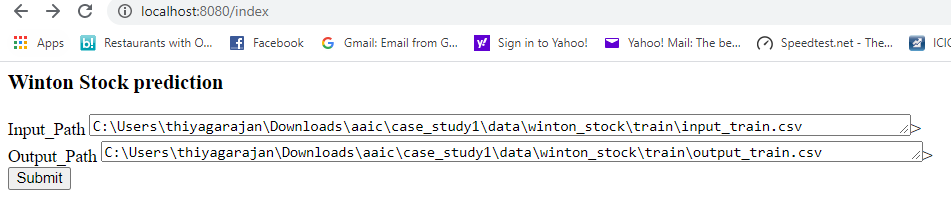

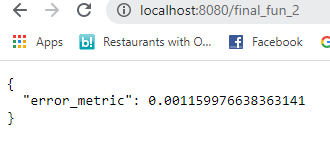